# Fundamental frequency estimation with Echo State Networks

This notebook serves as the supplemental material for the paper entitled "FUNDAMENTAL FREQUENCY ESTIMATION WITH
ECHO STATE NETWORKS" submitted to ICASSP 2022.

![Algorithm outline](img/f0_estimation_ICASSP_2022.png)

In [1]:
import os
import glob
import numpy as np

import time
import librosa
import pandas as pd
import seaborn as sns

from joblib import dump, load

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import make_scorer, zero_one_loss
from sklearn.metrics import mean_squared_error as mse
from pyrcn.metrics import mean_squared_error
from pyrcn.model_selection import SequentialSearchCV
from pyrcn.util import FeatureExtractor
from pyrcn.datasets import fetch_ptdb_tug_dataset
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import PredefinedWeightsInputToNode
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex': True,
          'font.size': 8,
          'font.family': 'lmodern',
         }
plt.rcParams.update(params)
mpl.rc('font', **{'family': 'serif'})
from matplotlib import ticker
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

c:\users\steiner\.virtualenvs\pyrcn\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
c:\users\steiner\.virtualenvs\pyrcn\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


## Feature Extraction

We use Mel-spectrograms as features, because they are on the one hand rather low-dimensional and on the other hand still keep the most important f0 information. The starting point was an audio signal (sampling frequency 16 kHz), that was divided in
frames of 1024 samples (64 ms) at a frame rate of 100 Hz. Each frame was windowed using a Hann window, and then the magnitude
spectrum was computed. Next, we reduced the dimensionality of the magnitude spectra by applying a bank of 80 triangular filters in the frequency domain with center frequencies between 40 Hz and 4000 Hz, equally spaced on the Mel-scale. We computed a logarithmic magnitude band and obtained the final feature set with 80 features per frame.

In [2]:
def create_feature_extraction_pipeline(sr=16000):
    audio_loading = Pipeline([("load_audio", FeatureExtractor(func=librosa.load, kw_args={"sr": sr, "mono": True})),
                              ("normalize", FeatureExtractor(func=librosa.util.normalize, kw_args={"norm": np.inf}))])
    
    feature_extractor = Pipeline([("mel_spectrogram", FeatureExtractor(func=librosa.feature.melspectrogram, 
                                                                       kw_args={"sr": sr, "n_fft": 1024, "hop_length": 160, 
                                                                                "window": 'hann', "center": False, 
                                                                                "power": 2.0, "n_mels": 80, "fmin": 40, 
                                                                                "fmax": 4000, "htk": True})),
                                            ("power_to_db", FeatureExtractor(func=librosa.power_to_db, kw_args={"ref": 1}))])

    feature_extraction_pipeline = Pipeline([("audio_loading", audio_loading),
                                            ("feature_extractor", feature_extractor)])
    return feature_extraction_pipeline

## Load and preprocess the dataset

This might require a large amount of time and memory. 

In [3]:
# Load and preprocess the dataset
feature_extraction_pipeline = create_feature_extraction_pipeline()

X_train, X_test, y_train, y_test = fetch_ptdb_tug_dataset(data_origin="Z:/Projekt-Pitch-Datenbank/SPEECH_DATA", 
                                                          data_home=None, preprocessor=feature_extraction_pipeline, 
                                                          force_preprocessing=False, augment=0)

Feature visualization. All features carry information, since the variance is always large

We can fit a StandardScaler here!

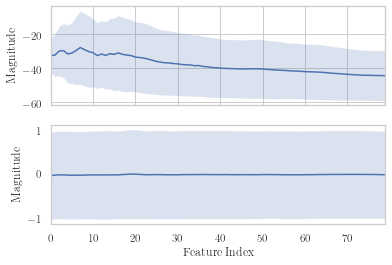

In [4]:
def tsplot(ax, data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

fig, axs = plt.subplots(2, 1, sharex=True)

tsplot(axs[0], np.concatenate(np.hstack((X_train, X_test))))
axs[0].set_ylabel('Magnitude')
scaler = StandardScaler().fit(np.concatenate(X_train))
for k, X in enumerate(X_train):
    X_train[k] = scaler.transform(X=X)
for k, X in enumerate(X_test):
    X_test[k] = scaler.transform(X=X)
tsplot(axs[1], np.concatenate(np.hstack((X_train, X_test))))
axs[1].set_xlabel('Feature Index')
axs[1].set_ylabel('Magnitude')
plt.grid()
# plt.savefig('features_statistics.pdf', bbox_inches='tight', pad_inches=0)

In [5]:
all_y_train = []
for k in range(-3, 4):
    print(k)
    all_y_train.append(np.vstack((np.concatenate(y_train), np.concatenate(y_test)))[:, 0] * 2**(k/12))
all_y_test = []
for k in range(0, 1):
    print(k)
    all_y_test.append(np.concatenate(y_test)[:, 0] * 2**(k/12))

all_y_train = np.concatenate(all_y_train)
all_y_test = np.concatenate(all_y_test)

-3
-2
-1
0
1
2
3
0


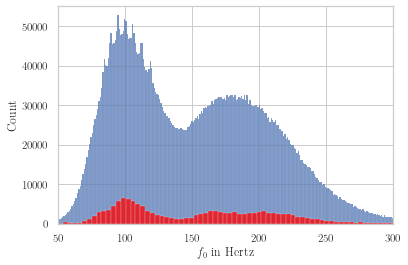

In [6]:
fig, ax = plt.subplots()

sns.histplot(x=all_y_train[all_y_train!=0], stat="count", label="Training set", ax=ax)  # , log_scale=True
sns.histplot(x=all_y_test[all_y_test!=0], stat="count", label="Test set", color="red", ax=ax)  # , log_scale=True
plt.xlabel(r"$f_{0}$ in Hertz")
plt.ylabel(r"Count")
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlim([50, 300])
ax.set_ylim([0, 55000])
plt.minorticks_off()

Define several error functions for $f_{0}$ extraction

In [7]:
def gpe(y_true, y_pred):
    """
    Gross pitch error:
    
    All frames that are considered voiced by both pitch tracker and ground truth, 
    for which the relative pitch error is higher than a certain threshold (\SI{20}{\percent}).
    
    """
    idx = np.nonzero(y_true*y_pred)[0]
    if idx.size == 0:
        return np.inf
    else:
        return np.sum(np.abs(y_true[idx] - y_pred[idx]) > 0.2 * y_true[idx]) / len(np.nonzero(y_true)[0])


def vde(y_true, y_pred):
    """
    Voicing Decision Error:
    
    Proportion of frames for which an incorrect voiced/unvoiced decision is made.
    
    """
    return zero_one_loss(y_true, y_pred)


def fpe(y_true, y_pred):
    """
    Fine Pitch Error:
    
    Standard deviation of the distribution of relative error values (in cents) from the frames
    that do not have gross pitch errors
    """
    idx_voiced = np.nonzero(y_true * y_pred)[0]
    idx_correct = np.argwhere(np.abs(y_true - y_pred) <= 0.2 * y_true).ravel()
    idx = np.intersect1d(idx_voiced, idx_correct)
    if idx.size == 0:
        return 0
    else:
        return 100 * np.std(np.log2(y_pred[idx] / y_true[idx]))


def mu_fpe(y_true, y_pred):
    """
    Mean Fine Pitch Error:
    
    Standard deviation of the distribution of relative error values (in cents) from the frames
    that do not have gross pitch errors
    """
    idx_voiced = np.nonzero(y_true * y_pred)[0]
    idx_correct = np.argwhere(np.abs(1 / y_true - 1 / y_pred) < 0.625e-3).ravel()
    idx = np.intersect1d(idx_voiced, idx_correct)
    if idx.size == 0:
        return 0
    else:
        return np.mean(np.abs(y_pred[idx] - y_true[idx]))
    
    
def ffe(y_true, y_pred):
    """
    $f_{0}$ Frame Error:
    
    Proportion of frames for which an error (either according to the GPE or the VDE criterion) is made.
    FFE can be seen as a single measure for assessing the overall performance of a pitch tracker.
    """
    idx_correct = np.argwhere(np.abs(y_true - y_pred) <= 0.2 * y_true).ravel()
    return 1 - len(idx_correct) / len(y_true)

In [129]:
def gpe_scorer(y_true, y_pred):
    gross_pitch_error = np.zeros(shape=(len(y_true),))
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        gross_pitch_error[k] = gpe(y_true=y_t[:, 0]*(y_t[:, 1] > 0.5),
                                   y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(gross_pitch_error)


def fpe_scorer(y_true, y_pred):
    fine_pitch_error = np.zeros(shape=(len(y_true),))
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        fine_pitch_error[k] = fpe(y_true=y_t[:, 0]*(y_t[:, 1] > 0.5),
                                  y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(fine_pitch_error)


def mu_fpe_scorer(y_true, y_pred):
    fine_pitch_error = np.zeros(shape=(len(y_true),))
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        fine_pitch_error[k] = mu_fpe(y_true=y_t[:, 0]*(y_t[:, 1] > 0.5),
                                     y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(fine_pitch_error)


def vde_scorer(y_true, y_pred):
    voicing_decision_error = np.zeros(shape=(len(y_true),))
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        voicing_decision_error[k] = vde(y_true=(y_t[:, 1] > 0.5),
                                        y_pred=y_p[:, 1] >= .5)
    return np.mean(voicing_decision_error)


def ffe_scorer(y_true, y_pred):
    frame_fault_error = np.zeros(shape=(len(y_true),))
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        frame_fault_error[k] = ffe(y_true=y_t[:, 0]*(y_t[:, 1] > 0.5),
                                   y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(frame_fault_error)

## Set up a ESN

To develop an ESN model for multipitch tracking, we need to tune several hyper-parameters, e.g., input_scaling, spectral_radius, bias_scaling and leaky integration.

We follow the way proposed in the paper for multipitch tracking and for acoustic modeling of piano music to optimize hyper-parameters sequentially.

We define the search spaces for each step together with the type of search (a grid search in this context).

At last, we initialize an```ESNRegressor```ESNRegressor with the desired output strategy and with the initially fixed parameters.

In [8]:
def custom_scorer(y_true, y_pred):
    gross_pitch_error = np.zeros(shape=(len(y_true),))
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        gross_pitch_error[k] = gpe(y_true=y_t[:, 0]*(y_t[:, 1] > 0.5),
                                   y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(gross_pitch_error)


gpe_scorer = make_scorer(custom_scorer, greater_is_better=False)

initially_fixed_params = {'hidden_layer_size': 500,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 1.0,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bidirectional': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': uniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': uniform(loc=0, scale=3)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1,
                'scoring': gpe_scorer}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1,
                'scoring': gpe_scorer}
kwargs_step3 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1,
                'scoring': gpe_scorer}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1,
                'scoring': gpe_scorer}

searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', RandomizedSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_esn = ESNRegressor(**initially_fixed_params)

## Optimization

We provide a SequentialSearchCV that basically iterates through the list of searches that we have defined before. It can be combined with any model selection tool from scikit-learn.

In [9]:
try: 
    sequential_search = load("../f0/sequential_search_f0_mel_500.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train, y_train)
    dump(sequential_search, "../f0/sequential_search_f0_mel_500.joblib")

## Visualize hyper-parameter optimization

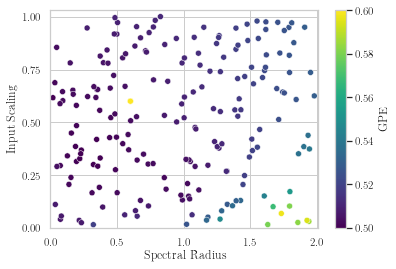

In [15]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = - df["mean_test_score"]
df[df["mean_test_score"] > 0.6] = 0.6
fig, axs = plt.subplots()
sns.scatterplot(x="param_spectral_radius", y="param_input_scaling",
                hue="mean_test_score", palette='viridis', data=df, ax=axs)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(0.5, 0.6)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
# sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
axs.get_legend().remove()
axs.figure.colorbar(sm, label='GPE')
# fig.set_size_inches(2, 1.25)
axs.yaxis.set_major_locator(ticker.MaxNLocator(5))
axs.xaxis.set_major_locator(ticker.MaxNLocator(5))
# plt.savefig('optimize_is_sr_50.pdf', bbox_inches='tight', pad_inches=0)

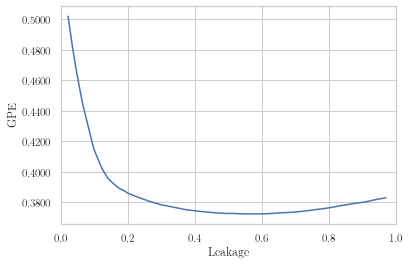

In [17]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig, axs = plt.subplots()
# fig.set_size_inches(2, 1.25)
sns.lineplot(data=df, x="param_leakage", y="mean_test_score", ax=axs)
plt.xlabel("Leakage")
plt.ylabel("GPE")
plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
axs.xaxis.set_major_locator(tick_locator)
axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
# plt.grid()
# plt.savefig('optimize_leakage_50.pdf', bbox_inches='tight', pad_inches=0)

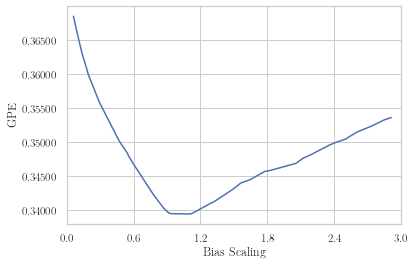

In [18]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig, axs = plt.subplots()
sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score", ax=axs)
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 3))
tick_locator = ticker.MaxNLocator(5)
axs.xaxis.set_major_locator(tick_locator)
axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
# plt.grid()
# plt.savefig('optimize_bias_scaling_50.pdf', bbox_inches='tight', pad_inches=0)

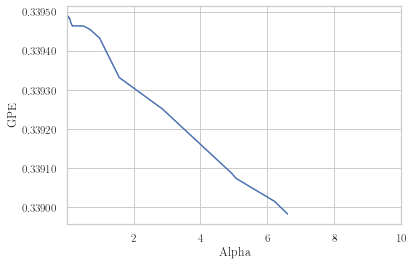

In [19]:
df = pd.DataFrame(sequential_search.all_cv_results_["step4"])
df["mean_test_score"] = -df["mean_test_score"]
fig, axs = plt.subplots()
sns.lineplot(data=df, x="param_alpha", y="mean_test_score", ax=axs)
plt.xlabel("Alpha")
plt.ylabel("GPE")
plt.xlim((1e-5, 10))
ax.set(xscale='log')
tick_locator = ticker.MaxNLocator(5)
axs.xaxis.set_major_locator(tick_locator)
axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
# plt.grid()
# plt.savefig('optimize_alpha_50.pdf', bbox_inches='tight', pad_inches=0)

In [20]:
sequential_search.all_best_params_

{'step1': {'input_scaling': 0.29975145291376804,
  'spectral_radius': 0.32244257450800884},
 'step2': {'leakage': 0.6075548519014383},
 'step3': {'bias_scaling': 1.099085529881075},
 'step4': {'alpha': 6.598711072054071}}

## Final evaluation

Increase the reservoir size from 50 neurons as large as possible by doubling the value

In [139]:
def gpe_scorer(y_true, y_pred):
    gross_pitch_error = np.zeros(shape=(len(y_true),))
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        gross_pitch_error[k] = gpe(y_true=y_t[:, 0]*(y_t[:, 1] > 0.5),
                                   y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(gross_pitch_error)


print("Parameters\tFit time\tInference time\tGPE\tFPE\tVDE")
param_grid = {'hidden_layer_size': [50, 100, 200, 400, 500, 800, 1000, 1600],
              'random_state': [1, 2, 3, 4, 5]}
for params in ParameterGrid(param_grid):
    esn = clone(sequential_search.best_estimator_).set_params(**params)
    t1 = time.time()
    esn.fit(X_train, y_train, n_jobs=-1)
    t2 = time.time()
    y_pred = esn.predict(X_test)
    t3 = time.time()
    print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}"
          .format(params, t2-t1, t3-t2, gpe_scorer(y_test, y_pred),
                  fpe_scorer(y_test, y_pred), vde_scorer(y_test, y_pred)))

Parameters	Fit time	Inference time	GPE	FPE	VDE


c:\users\steiner\.virtualenvs\pyrcn\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
c:\users\steiner\.virtualenvs\pyrcn\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in subtract


{'hidden_layer_size': 1600}	4366.426821470261	1009.3675124645233	0.41372121487197266	7.6790550435635385	0.04653028235295377


$K$-Means initialization

In [21]:
t1 = time.time()
kmeans = MiniBatchKMeans(n_clusters=500, n_init=200, reassignment_ratio=0,
                         max_no_improvement=50, init='k-means++', verbose=2,
                         random_state=0)
kmeans.fit(X=np.concatenate(np.concatenate((X_train, X_test))))
print("done in {0}!".format(time.time() - t1))

Init 1/200 with method k-means++
Inertia for init 1/200: 21852.189453125
Init 2/200 with method k-means++
Inertia for init 2/200: 21833.546875
Init 3/200 with method k-means++
Inertia for init 3/200: 21939.443359375
Init 4/200 with method k-means++
Inertia for init 4/200: 21905.640625
Init 5/200 with method k-means++
Inertia for init 5/200: 22424.18359375
Init 6/200 with method k-means++
Inertia for init 6/200: 21846.55859375
Init 7/200 with method k-means++
Inertia for init 7/200: 22142.095703125
Init 8/200 with method k-means++
Inertia for init 8/200: 21923.45703125
Init 9/200 with method k-means++
Inertia for init 9/200: 21929.75
Init 10/200 with method k-means++
Inertia for init 10/200: 22100.16015625
Init 11/200 with method k-means++
Inertia for init 11/200: 22069.662109375
Init 12/200 with method k-means++
Inertia for init 12/200: 21864.6328125
Init 13/200 with method k-means++
Inertia for init 13/200: 21978.08984375
Init 14/200 with method k-means++
Inertia for init 14/200: 2207

Inertia for init 112/200: 21876.826171875
Init 113/200 with method k-means++
Inertia for init 113/200: 22015.072265625
Init 114/200 with method k-means++
Inertia for init 114/200: 22191.787109375
Init 115/200 with method k-means++
Inertia for init 115/200: 21915.0078125
Init 116/200 with method k-means++
Inertia for init 116/200: 21894.142578125
Init 117/200 with method k-means++
Inertia for init 117/200: 21964.484375
Init 118/200 with method k-means++
Inertia for init 118/200: 21906.67578125
Init 119/200 with method k-means++
Inertia for init 119/200: 21963.462890625
Init 120/200 with method k-means++
Inertia for init 120/200: 22070.2734375
Init 121/200 with method k-means++
Inertia for init 121/200: 21887.15625
Init 122/200 with method k-means++
Inertia for init 122/200: 22197.98046875
Init 123/200 with method k-means++
Inertia for init 123/200: 21947.509765625
Init 124/200 with method k-means++
Inertia for init 124/200: 22090.333984375
Init 125/200 with method k-means++
Inertia for 

Minibatch step 30/334865: mean batch inertia: 5.4169816970825195, ewa inertia: 6.789218778154365
Minibatch step 31/334865: mean batch inertia: 5.024426460266113, ewa inertia: 6.788164748623228
Minibatch step 32/334865: mean batch inertia: 5.604048728942871, ewa inertia: 6.787457530419486
Minibatch step 33/334865: mean batch inertia: 5.563289642333984, ewa inertia: 6.786726391071228
Minibatch step 34/334865: mean batch inertia: 5.101449966430664, ewa inertia: 6.785719852737116
Minibatch step 35/334865: mean batch inertia: 5.095578670501709, ewa inertia: 6.784710408906355
Minibatch step 36/334865: mean batch inertia: 5.148988246917725, ewa inertia: 6.783733467061133
Minibatch step 37/334865: mean batch inertia: 5.38388729095459, ewa inertia: 6.782897403126748
Minibatch step 38/334865: mean batch inertia: 5.363663673400879, ewa inertia: 6.782049759895557
Minibatch step 39/334865: mean batch inertia: 5.176660537719727, ewa inertia: 6.781090934524441
Minibatch step 40/334865: mean batch ine

Minibatch step 152/334865: mean batch inertia: 4.905517101287842, ewa inertia: 6.673309498540126
Minibatch step 153/334865: mean batch inertia: 4.864629745483398, ewa inertia: 6.672229257056316
Minibatch step 154/334865: mean batch inertia: 5.257876873016357, ewa inertia: 6.671384529229081
Minibatch step 155/334865: mean batch inertia: 4.788508415222168, ewa inertia: 6.670259973660973
Minibatch step 156/334865: mean batch inertia: 5.051568031311035, ewa inertia: 6.669293203185061
Minibatch step 157/334865: mean batch inertia: 5.1003828048706055, ewa inertia: 6.6683561649427885
Minibatch step 158/334865: mean batch inertia: 5.417302131652832, ewa inertia: 6.6676089677328
Minibatch step 159/334865: mean batch inertia: 5.156441688537598, ewa inertia: 6.666706416807904
Minibatch step 160/334865: mean batch inertia: 5.112977027893066, ewa inertia: 6.665778445486456
Minibatch step 161/334865: mean batch inertia: 5.15726375579834, ewa inertia: 6.664877478831644
Minibatch step 162/334865: mean

Minibatch step 238/334865: mean batch inertia: 5.241104602813721, ewa inertia: 6.592441295469935
Minibatch step 239/334865: mean batch inertia: 5.056229591369629, ewa inertia: 6.591523786658396
Minibatch step 240/334865: mean batch inertia: 4.8264617919921875, ewa inertia: 6.590469596061685
Minibatch step 241/334865: mean batch inertia: 5.248981952667236, ewa inertia: 6.589668387002998
Minibatch step 242/334865: mean batch inertia: 5.090551853179932, ewa inertia: 6.588773033435755
Minibatch step 243/334865: mean batch inertia: 5.225979328155518, ewa inertia: 6.5879590992432435
Minibatch step 244/334865: mean batch inertia: 4.744134902954102, ewa inertia: 6.586857867594956
Minibatch step 245/334865: mean batch inertia: 5.292102813720703, ewa inertia: 6.586084569769179
Minibatch step 246/334865: mean batch inertia: 4.826657295227051, ewa inertia: 6.585033744532431
Minibatch step 247/334865: mean batch inertia: 5.266993522644043, ewa inertia: 6.584246539543485
Minibatch step 248/334865: m

Minibatch step 361/334865: mean batch inertia: 5.078463077545166, ewa inertia: 6.4821692838010785
Minibatch step 362/334865: mean batch inertia: 5.192841529846191, ewa inertia: 6.4813992274526875
Minibatch step 363/334865: mean batch inertia: 5.057297706604004, ewa inertia: 6.48054867691306
Minibatch step 364/334865: mean batch inertia: 4.919827461242676, ewa inertia: 6.479616529694085
Minibatch step 365/334865: mean batch inertia: 4.969316482543945, ewa inertia: 6.478714496727124
Minibatch step 366/334865: mean batch inertia: 5.160580158233643, ewa inertia: 6.4779272355266455
Minibatch step 367/334865: mean batch inertia: 4.988039970397949, ewa inertia: 6.4770373941784065
Minibatch step 368/334865: mean batch inertia: 4.949121952056885, ewa inertia: 6.476124840343742
Minibatch step 369/334865: mean batch inertia: 5.1467485427856445, ewa inertia: 6.475330864836586
Minibatch step 370/334865: mean batch inertia: 5.147951602935791, ewa inertia: 6.47453808206726
Minibatch step 371/334865: 

Minibatch step 481/334865: mean batch inertia: 5.221899032592773, ewa inertia: 6.382665467585064
Minibatch step 482/334865: mean batch inertia: 4.849039077758789, ewa inertia: 6.381749502863197
Minibatch step 483/334865: mean batch inertia: 5.130552291870117, ewa inertia: 6.381002220139732
Minibatch step 484/334865: mean batch inertia: 4.86440896987915, ewa inertia: 6.380096428531114
Minibatch step 485/334865: mean batch inertia: 4.8142805099487305, ewa inertia: 6.3791612384796945
Minibatch step 486/334865: mean batch inertia: 5.08233642578125, ewa inertia: 6.3783867044818745
Minibatch step 487/334865: mean batch inertia: 4.943539142608643, ewa inertia: 6.377529735824676
Minibatch step 488/334865: mean batch inertia: 4.988884925842285, ewa inertia: 6.376700361952666
Minibatch step 489/334865: mean batch inertia: 5.194864273071289, ewa inertia: 6.375994505447048
Minibatch step 490/334865: mean batch inertia: 4.931870937347412, ewa inertia: 6.37513199665666
Minibatch step 491/334865: mea

Minibatch step 565/334865: mean batch inertia: 4.883873462677002, ewa inertia: 6.316074073932637
Minibatch step 566/334865: mean batch inertia: 4.977653980255127, ewa inertia: 6.315274696980742
Minibatch step 567/334865: mean batch inertia: 5.240276336669922, ewa inertia: 6.314632649751611
Minibatch step 568/334865: mean batch inertia: 4.871225357055664, ewa inertia: 6.313770568759679
Minibatch step 569/334865: mean batch inertia: 4.8283281326293945, ewa inertia: 6.312883382103995
Minibatch step 570/334865: mean batch inertia: 4.935981750488281, ewa inertia: 6.3120610218939674
Minibatch step 571/334865: mean batch inertia: 4.97440242767334, ewa inertia: 6.311262099750781
Minibatch step 572/334865: mean batch inertia: 4.912961483001709, ewa inertia: 6.310426958908133
Minibatch step 573/334865: mean batch inertia: 4.904548645019531, ewa inertia: 6.309587292254441
Minibatch step 574/334865: mean batch inertia: 4.9740071296691895, ewa inertia: 6.308789611463168
Minibatch step 575/334865: m

Minibatch step 650/334865: mean batch inertia: 4.6977128982543945, ewa inertia: 6.251669222698525
Minibatch step 651/334865: mean batch inertia: 5.079882621765137, ewa inertia: 6.250969368291265
Minibatch step 652/334865: mean batch inertia: 5.0916595458984375, ewa inertia: 6.250276965691733
Minibatch step 653/334865: mean batch inertia: 5.028986930847168, ewa inertia: 6.249547545153259
Minibatch step 654/334865: mean batch inertia: 4.972361087799072, ewa inertia: 6.248784740244617
Minibatch step 655/334865: mean batch inertia: 5.015859127044678, ewa inertia: 6.248048370308713
Minibatch step 656/334865: mean batch inertia: 4.7765045166015625, ewa inertia: 6.247169484639024
Minibatch step 657/334865: mean batch inertia: 4.921307563781738, ewa inertia: 6.246377608107929
Minibatch step 658/334865: mean batch inertia: 5.131279468536377, ewa inertia: 6.245711611119326
Minibatch step 659/334865: mean batch inertia: 5.051581382751465, ewa inertia: 6.244998411887912
Minibatch step 660/334865: 

Minibatch step 736/334865: mean batch inertia: 4.8300981521606445, ewa inertia: 6.189271861727579
Minibatch step 737/334865: mean batch inertia: 4.904845714569092, ewa inertia: 6.188504732884175
Minibatch step 738/334865: mean batch inertia: 4.920949935913086, ewa inertia: 6.187747680524642
Minibatch step 739/334865: mean batch inertia: 5.027181625366211, ewa inertia: 6.187054527634881
Minibatch step 740/334865: mean batch inertia: 4.845096111297607, ewa inertia: 6.186253037405102
Minibatch step 741/334865: mean batch inertia: 5.128312110900879, ewa inertia: 6.185621177799057
Minibatch step 742/334865: mean batch inertia: 4.914735794067383, ewa inertia: 6.184862136232769
Minibatch step 743/334865: mean batch inertia: 4.760612487792969, ewa inertia: 6.184011497223323
Minibatch step 744/334865: mean batch inertia: 4.947158336639404, ewa inertia: 6.1832727815434545
Minibatch step 745/334865: mean batch inertia: 5.086722373962402, ewa inertia: 6.182617862264707
Minibatch step 746/334865: m

Minibatch step 824/334865: mean batch inertia: 5.0573625564575195, ewa inertia: 6.127200750645339
Minibatch step 825/334865: mean batch inertia: 4.9119110107421875, ewa inertia: 6.126474913807904
Minibatch step 826/334865: mean batch inertia: 4.818584442138672, ewa inertia: 6.12569377079937
Minibatch step 827/334865: mean batch inertia: 5.076206207275391, ewa inertia: 6.125066959999423
Minibatch step 828/334865: mean batch inertia: 5.216801643371582, ewa inertia: 6.124524494772139
Minibatch step 829/334865: mean batch inertia: 4.914089202880859, ewa inertia: 6.123801557273913
Minibatch step 830/334865: mean batch inertia: 4.943501949310303, ewa inertia: 6.123096618437896
Minibatch step 831/334865: mean batch inertia: 5.008321762084961, ewa inertia: 6.122430814531535
Minibatch step 832/334865: mean batch inertia: 5.332563877105713, ewa inertia: 6.121959063227273
Minibatch step 833/334865: mean batch inertia: 4.853399276733398, ewa inertia: 6.121201410633581
Minibatch step 834/334865: me

Minibatch step 914/334865: mean batch inertia: 4.856255531311035, ewa inertia: 6.0681412005314
Minibatch step 915/334865: mean batch inertia: 4.833063125610352, ewa inertia: 6.067403545028806
Minibatch step 916/334865: mean batch inertia: 5.21964168548584, ewa inertia: 6.0668972157421965
Minibatch step 917/334865: mean batch inertia: 5.056811809539795, ewa inertia: 6.066293938044126
Minibatch step 918/334865: mean batch inertia: 5.089400291442871, ewa inertia: 6.065710484262136
Minibatch step 919/334865: mean batch inertia: 5.052265167236328, ewa inertia: 6.065105199843392
Minibatch step 920/334865: mean batch inertia: 5.05495548248291, ewa inertia: 6.064501883735216
Minibatch step 921/334865: mean batch inertia: 4.886663436889648, ewa inertia: 6.063798414837884
Minibatch step 922/334865: mean batch inertia: 5.333703994750977, ewa inertia: 6.063362362917503
Minibatch step 923/334865: mean batch inertia: 5.00857400894165, ewa inertia: 6.0627323861984745
Minibatch step 924/334865: mean b

Minibatch step 1001/334865: mean batch inertia: 5.100284099578857, ewa inertia: 6.014492510067046
Minibatch step 1002/334865: mean batch inertia: 4.995804786682129, ewa inertia: 6.013884094599361
Minibatch step 1003/334865: mean batch inertia: 5.039405822753906, ewa inertia: 6.013302083409963
Minibatch step 1004/334865: mean batch inertia: 4.968768119812012, ewa inertia: 6.012678231168117
Minibatch step 1005/334865: mean batch inertia: 4.841692924499512, ewa inertia: 6.011978855337179
Minibatch step 1006/334865: mean batch inertia: 5.144871234893799, ewa inertia: 6.011460971714638
Minibatch step 1007/334865: mean batch inertia: 5.037341594696045, ewa inertia: 6.010879174876663
Minibatch step 1008/334865: mean batch inertia: 5.062841415405273, ewa inertia: 6.010312955392938
Minibatch step 1009/334865: mean batch inertia: 4.888002872467041, ewa inertia: 6.009642651041255
Minibatch step 1010/334865: mean batch inertia: 5.05676794052124, ewa inertia: 6.009073542668456
Minibatch step 1011/3

Minibatch step 1087/334865: mean batch inertia: 4.97504997253418, ewa inertia: 5.963808229497765
Minibatch step 1088/334865: mean batch inertia: 4.893098831176758, ewa inertia: 5.9631687438689704
Minibatch step 1089/334865: mean batch inertia: 5.06868839263916, ewa inertia: 5.9626345117694415
Minibatch step 1090/334865: mean batch inertia: 5.0781025886535645, ewa inertia: 5.962106221409864
Minibatch step 1091/334865: mean batch inertia: 5.175893306732178, ewa inertia: 5.9616366524858435
Minibatch step 1092/334865: mean batch inertia: 5.007511138916016, ewa inertia: 5.961066797065735
Minibatch step 1093/334865: mean batch inertia: 5.023710250854492, ewa inertia: 5.960506956980929
Minibatch step 1094/334865: mean batch inertia: 5.086526870727539, ewa inertia: 5.959984968749679
Minibatch step 1095/334865: mean batch inertia: 4.886396408081055, ewa inertia: 5.959343763529232
Minibatch step 1096/334865: mean batch inertia: 5.104167461395264, ewa inertia: 5.958833005936035
Minibatch step 109

Minibatch step 1173/334865: mean batch inertia: 4.819389343261719, ewa inertia: 5.915938027978604
Minibatch step 1174/334865: mean batch inertia: 4.678472518920898, ewa inertia: 5.91519894657107
Minibatch step 1175/334865: mean batch inertia: 4.971290111541748, ewa inertia: 5.914635193104592
Minibatch step 1176/334865: mean batch inertia: 4.88068962097168, ewa inertia: 5.914017664823462
Minibatch step 1177/334865: mean batch inertia: 5.049962520599365, ewa inertia: 5.913501604305003
Minibatch step 1178/334865: mean batch inertia: 5.018649578094482, ewa inertia: 5.91296715022105
Minibatch step 1179/334865: mean batch inertia: 4.844290256500244, ewa inertia: 5.9123288785140575
Minibatch step 1180/334865: mean batch inertia: 4.838019847869873, ewa inertia: 5.911687242989929
Minibatch step 1181/334865: mean batch inertia: 4.860914707183838, ewa inertia: 5.911059664734958
Minibatch step 1182/334865: mean batch inertia: 4.961118221282959, ewa inertia: 5.91049230826808
Minibatch step 1183/334

Minibatch step 1262/334865: mean batch inertia: 4.883395671844482, ewa inertia: 5.867535005595008
Minibatch step 1263/334865: mean batch inertia: 4.744248390197754, ewa inertia: 5.866864118005257
Minibatch step 1264/334865: mean batch inertia: 5.120741367340088, ewa inertia: 5.866418493097962
Minibatch step 1265/334865: mean batch inertia: 5.189228534698486, ewa inertia: 5.866014038586738
Minibatch step 1266/334865: mean batch inertia: 5.049272060394287, ewa inertia: 5.865526236052918
Minibatch step 1267/334865: mean batch inertia: 4.93342399597168, ewa inertia: 5.864969534124239
Minibatch step 1268/334865: mean batch inertia: 5.1578569412231445, ewa inertia: 5.864547208195459
Minibatch step 1269/334865: mean batch inertia: 4.725813865661621, ewa inertia: 5.8638670949838625
Minibatch step 1270/334865: mean batch inertia: 5.084137439727783, ewa inertia: 5.863401398213419
Minibatch step 1271/334865: mean batch inertia: 5.017250061035156, ewa inertia: 5.862896030817971
Minibatch step 1272

Minibatch step 1351/334865: mean batch inertia: 4.77543830871582, ewa inertia: 5.822172973397358
Minibatch step 1352/334865: mean batch inertia: 4.890592575073242, ewa inertia: 5.821616583140834
Minibatch step 1353/334865: mean batch inertia: 4.718918323516846, ewa inertia: 5.820957992031957
Minibatch step 1354/334865: mean batch inertia: 4.720400333404541, ewa inertia: 5.820300679405903
Minibatch step 1355/334865: mean batch inertia: 5.317873954772949, ewa inertia: 5.820000602960857
Minibatch step 1356/334865: mean batch inertia: 5.053815841674805, ewa inertia: 5.819542995934513
Minibatch step 1357/334865: mean batch inertia: 4.770223140716553, ewa inertia: 5.818916285299048
Minibatch step 1358/334865: mean batch inertia: 5.000031471252441, ewa inertia: 5.818427202947626
Minibatch step 1359/334865: mean batch inertia: 4.991686820983887, ewa inertia: 5.817933428825684
Minibatch step 1360/334865: mean batch inertia: 4.990180492401123, ewa inertia: 5.817439049951393
Minibatch step 1361/3

Minibatch step 1438/334865: mean batch inertia: 5.172183513641357, ewa inertia: 5.778992119476683
Minibatch step 1439/334865: mean batch inertia: 4.8230204582214355, ewa inertia: 5.778421161437213
Minibatch step 1440/334865: mean batch inertia: 4.982115268707275, ewa inertia: 5.7779455644401905
Minibatch step 1441/334865: mean batch inertia: 4.879546165466309, ewa inertia: 5.777408991673143
Minibatch step 1442/334865: mean batch inertia: 4.950962066650391, ewa inertia: 5.776915392819577
Minibatch step 1443/334865: mean batch inertia: 4.990060806274414, ewa inertia: 5.7764454406543715
Minibatch step 1444/334865: mean batch inertia: 5.047001838684082, ewa inertia: 5.776009777437809
Minibatch step 1445/334865: mean batch inertia: 5.099294185638428, ewa inertia: 5.775605606244006
Minibatch step 1446/334865: mean batch inertia: 4.993135452270508, ewa inertia: 5.775138272699338
Minibatch step 1447/334865: mean batch inertia: 4.840690612792969, ewa inertia: 5.774580169958942
Minibatch step 14

Minibatch step 1527/334865: mean batch inertia: 5.229128360748291, ewa inertia: 5.73722987367735
Minibatch step 1528/334865: mean batch inertia: 5.184391021728516, ewa inertia: 5.736899688380186
Minibatch step 1529/334865: mean batch inertia: 5.094241619110107, ewa inertia: 5.736515858182962
Minibatch step 1530/334865: mean batch inertia: 4.846259593963623, ewa inertia: 5.735984148936919
Minibatch step 1531/334865: mean batch inertia: 5.047748565673828, ewa inertia: 5.735573097380435
Minibatch step 1532/334865: mean batch inertia: 4.699643611907959, ewa inertia: 5.7349543841988355
Minibatch step 1533/334865: mean batch inertia: 5.157472133636475, ewa inertia: 5.734609480529644
Minibatch step 1534/334865: mean batch inertia: 4.781094551086426, ewa inertia: 5.734039989783438
Minibatch step 1535/334865: mean batch inertia: 4.8815531730651855, ewa inertia: 5.73353083849656
Minibatch step 1536/334865: mean batch inertia: 4.990900993347168, ewa inertia: 5.7330872997415705
Minibatch step 1537

Minibatch step 1615/334865: mean batch inertia: 5.009903907775879, ewa inertia: 5.697924651165395
Minibatch step 1616/334865: mean batch inertia: 4.905458927154541, ewa inertia: 5.697451347725067
Minibatch step 1617/334865: mean batch inertia: 4.736271858215332, ewa inertia: 5.6968772792885725
Minibatch step 1618/334865: mean batch inertia: 5.003594398498535, ewa inertia: 5.6964632132127075
Minibatch step 1619/334865: mean batch inertia: 4.821400165557861, ewa inertia: 5.69594057817827
Minibatch step 1620/334865: mean batch inertia: 4.828423023223877, ewa inertia: 5.695422449720642
Minibatch step 1621/334865: mean batch inertia: 5.113400936126709, ewa inertia: 5.695074834957778
Minibatch step 1622/334865: mean batch inertia: 4.895821571350098, ewa inertia: 5.694597477631276
Minibatch step 1623/334865: mean batch inertia: 4.961358547210693, ewa inertia: 5.694159547639056
Minibatch step 1624/334865: mean batch inertia: 5.036649703979492, ewa inertia: 5.693766847157981
Minibatch step 1625

Minibatch step 1703/334865: mean batch inertia: 4.980785846710205, ewa inertia: 5.660471865886562
Minibatch step 1704/334865: mean batch inertia: 4.662109851837158, ewa inertia: 5.659875590033076
Minibatch step 1705/334865: mean batch inertia: 4.983831882476807, ewa inertia: 5.659471820124923
Minibatch step 1706/334865: mean batch inertia: 4.942526817321777, ewa inertia: 5.659043621748549
Minibatch step 1707/334865: mean batch inertia: 4.6550984382629395, ewa inertia: 5.6584440113239625
Minibatch step 1708/334865: mean batch inertia: 4.797542572021484, ewa inertia: 5.657929834368846
Minibatch step 1709/334865: mean batch inertia: 4.96840238571167, ewa inertia: 5.6575180112403975
Minibatch step 1710/334865: mean batch inertia: 4.987946510314941, ewa inertia: 5.657118106884497
Minibatch step 1711/334865: mean batch inertia: 4.827826023101807, ewa inertia: 5.656622808748063
Minibatch step 1712/334865: mean batch inertia: 5.0148115158081055, ewa inertia: 5.656239484291514
Minibatch step 17

Minibatch step 1794/334865: mean batch inertia: 4.755252361297607, ewa inertia: 5.622994307465457
Minibatch step 1795/334865: mean batch inertia: 4.803595542907715, ewa inertia: 5.62250491815496
Minibatch step 1796/334865: mean batch inertia: 4.91062068939209, ewa inertia: 5.622079742346872
Minibatch step 1797/334865: mean batch inertia: 4.986658096313477, ewa inertia: 5.6217002341334394
Minibatch step 1798/334865: mean batch inertia: 5.069588661193848, ewa inertia: 5.62137048320668
Minibatch step 1799/334865: mean batch inertia: 5.153273582458496, ewa inertia: 5.621090910391328
Minibatch step 1800/334865: mean batch inertia: 5.086297988891602, ewa inertia: 5.620771503100968
Minibatch step 1801/334865: mean batch inertia: 5.123867034912109, ewa inertia: 5.6204747248464875
Minibatch step 1802/334865: mean batch inertia: 5.063595294952393, ewa inertia: 5.620142126297388
Minibatch step 1803/334865: mean batch inertia: 5.024538516998291, ewa inertia: 5.6197863995715345
Minibatch step 1804/

Minibatch step 1882/334865: mean batch inertia: 4.951323986053467, ewa inertia: 5.589168105748934
Minibatch step 1883/334865: mean batch inertia: 4.988614082336426, ewa inertia: 5.58880942236772
Minibatch step 1884/334865: mean batch inertia: 5.042707443237305, ewa inertia: 5.588483260695788
Minibatch step 1885/334865: mean batch inertia: 5.001778602600098, ewa inertia: 5.588132848905448
Minibatch step 1886/334865: mean batch inertia: 5.0842790603637695, ewa inertia: 5.587831920140565
Minibatch step 1887/334865: mean batch inertia: 5.050838470458984, ewa inertia: 5.587511198575623
Minibatch step 1888/334865: mean batch inertia: 5.091160774230957, ewa inertia: 5.587214751226124
Minibatch step 1889/334865: mean batch inertia: 4.882915496826172, ewa inertia: 5.586794105575431
Minibatch step 1890/334865: mean batch inertia: 4.8385396003723145, ewa inertia: 5.586347207468897
Minibatch step 1891/334865: mean batch inertia: 4.983358860015869, ewa inertia: 5.585987070177555
Minibatch step 1892

Minibatch step 1970/334865: mean batch inertia: 4.926175594329834, ewa inertia: 5.558711682399016
Minibatch step 1971/334865: mean batch inertia: 4.998200416564941, ewa inertia: 5.5583769147208395
Minibatch step 1972/334865: mean batch inertia: 4.878870010375977, ewa inertia: 5.5579710764040415
Minibatch step 1973/334865: mean batch inertia: 4.969403266906738, ewa inertia: 5.5576195518388
Minibatch step 1974/334865: mean batch inertia: 4.968095779418945, ewa inertia: 5.557267456320738
Minibatch step 1975/334865: mean batch inertia: 5.16176700592041, ewa inertia: 5.557031242036443
Minibatch step 1976/334865: mean batch inertia: 5.118650913238525, ewa inertia: 5.556769417566935
Minibatch step 1977/334865: mean batch inertia: 5.074080944061279, ewa inertia: 5.556481129874237
Minibatch step 1978/334865: mean batch inertia: 5.0627570152282715, ewa inertia: 5.556186251099099
Minibatch step 1979/334865: mean batch inertia: 5.176375865936279, ewa inertia: 5.55595940777134
Minibatch step 1980/3

Minibatch step 2057/334865: mean batch inertia: 4.998022079467773, ewa inertia: 5.530417226514149
Minibatch step 2058/334865: mean batch inertia: 4.918202877044678, ewa inertia: 5.530051578954837
Minibatch step 2059/334865: mean batch inertia: 5.167445182800293, ewa inertia: 5.5298350107808645
Minibatch step 2060/334865: mean batch inertia: 5.049419403076172, ewa inertia: 5.529548080566693
Minibatch step 2061/334865: mean batch inertia: 4.997346878051758, ewa inertia: 5.529230221191247
Minibatch step 2062/334865: mean batch inertia: 5.051629543304443, ewa inertia: 5.528944972205583
Minibatch step 2063/334865: mean batch inertia: 4.675046920776367, ewa inertia: 5.52843497805292
Minibatch step 2064/334865: mean batch inertia: 5.101800918579102, ewa inertia: 5.528180169091483
Minibatch step 2065/334865: mean batch inertia: 4.893054962158203, ewa inertia: 5.527800837927531
Minibatch step 2066/334865: mean batch inertia: 5.147870063781738, ewa inertia: 5.527573922696952
Minibatch step 2067/

Minibatch step 2140/334865: mean batch inertia: 5.031399250030518, ewa inertia: 5.503966500809161
Minibatch step 2141/334865: mean batch inertia: 4.960639476776123, ewa inertia: 5.5036419964906695
Minibatch step 2142/334865: mean batch inertia: 5.160168647766113, ewa inertia: 5.503436855608626
Minibatch step 2143/334865: mean batch inertia: 4.800347805023193, ewa inertia: 5.503016932757181
Minibatch step 2144/334865: mean batch inertia: 4.896058559417725, ewa inertia: 5.502654424351412
Minibatch step 2145/334865: mean batch inertia: 4.982763290405273, ewa inertia: 5.502343917215472
Minibatch step 2146/334865: mean batch inertia: 4.878732681274414, ewa inertia: 5.5019714628184495
Minibatch step 2147/334865: mean batch inertia: 5.13037633895874, ewa inertia: 5.501749526089576
Minibatch step 2148/334865: mean batch inertia: 4.885318756103516, ewa inertia: 5.501381360255625
Minibatch step 2149/334865: mean batch inertia: 4.896335124969482, ewa inertia: 5.501019993882238
Minibatch step 2150

Minibatch step 2233/334865: mean batch inertia: 4.92704439163208, ewa inertia: 5.474386158280303
Minibatch step 2234/334865: mean batch inertia: 4.885097980499268, ewa inertia: 5.474034203472116
Minibatch step 2235/334865: mean batch inertia: 4.871576309204102, ewa inertia: 5.473674382996139
Minibatch step 2236/334865: mean batch inertia: 4.821771144866943, ewa inertia: 5.473285031083471
Minibatch step 2237/334865: mean batch inertia: 5.078035354614258, ewa inertia: 5.473048966574945
Minibatch step 2238/334865: mean batch inertia: 5.038735389709473, ewa inertia: 5.472789570989895
Minibatch step 2239/334865: mean batch inertia: 5.186903476715088, ewa inertia: 5.4726188243344085
Minibatch step 2240/334865: mean batch inertia: 4.969512462615967, ewa inertia: 5.472318341973295
Minibatch step 2241/334865: mean batch inertia: 5.062461853027344, ewa inertia: 5.472073553485438
Minibatch step 2242/334865: mean batch inertia: 4.814398765563965, ewa inertia: 5.471680754490719
Minibatch step 2243/

Minibatch step 2326/334865: mean batch inertia: 4.803142547607422, ewa inertia: 5.447250555740417
Minibatch step 2327/334865: mean batch inertia: 4.76953125, ewa inertia: 5.446845785074299
Minibatch step 2328/334865: mean batch inertia: 4.905787467956543, ewa inertia: 5.446522635750421
Minibatch step 2329/334865: mean batch inertia: 4.701934814453125, ewa inertia: 5.446077927586057
Minibatch step 2330/334865: mean batch inertia: 4.793564796447754, ewa inertia: 5.445688211412259
Minibatch step 2331/334865: mean batch inertia: 5.211182117462158, ewa inertia: 5.445548151675059
Minibatch step 2332/334865: mean batch inertia: 5.068601131439209, ewa inertia: 5.445323018503878
Minibatch step 2333/334865: mean batch inertia: 4.871883869171143, ewa inertia: 5.444980529593664
Minibatch step 2334/334865: mean batch inertia: 5.132019519805908, ewa inertia: 5.444793612332598
Minibatch step 2335/334865: mean batch inertia: 5.154345989227295, ewa inertia: 5.444620141285099
Minibatch step 2336/334865:

Minibatch step 2417/334865: mean batch inertia: 5.041096210479736, ewa inertia: 5.422728836002415
Minibatch step 2418/334865: mean batch inertia: 5.064499855041504, ewa inertia: 5.422514882257822
Minibatch step 2419/334865: mean batch inertia: 5.049576759338379, ewa inertia: 5.42229214341719
Minibatch step 2420/334865: mean batch inertia: 5.054349899291992, ewa inertia: 5.422072388385887
Minibatch step 2421/334865: mean batch inertia: 4.8632378578186035, ewa inertia: 5.421738622144802
Minibatch step 2422/334865: mean batch inertia: 5.0231828689575195, ewa inertia: 5.421500583068245
Minibatch step 2423/334865: mean batch inertia: 5.10306453704834, ewa inertia: 5.4213103958190825
Minibatch step 2424/334865: mean batch inertia: 4.678133010864258, ewa inertia: 5.420866530043673
Minibatch step 2425/334865: mean batch inertia: 4.944930076599121, ewa inertia: 5.4205822750229595
Minibatch step 2426/334865: mean batch inertia: 4.965314865112305, ewa inertia: 5.4203103646742194
Minibatch step 24

Minibatch step 2508/334865: mean batch inertia: 4.686301231384277, ewa inertia: 5.3990192184477594
Minibatch step 2509/334865: mean batch inertia: 4.893704891204834, ewa inertia: 5.398717417370079
Minibatch step 2510/334865: mean batch inertia: 4.914275646209717, ewa inertia: 5.398428082513085
Minibatch step 2511/334865: mean batch inertia: 4.730064392089844, ewa inertia: 5.3980288995270165
Minibatch step 2512/334865: mean batch inertia: 5.135664463043213, ewa inertia: 5.3978722012792
Minibatch step 2513/334865: mean batch inertia: 5.019062519073486, ewa inertia: 5.397645955625432
Minibatch step 2514/334865: mean batch inertia: 5.1449761390686035, ewa inertia: 5.397495047529573
Minibatch step 2515/334865: mean batch inertia: 4.945242404937744, ewa inertia: 5.397224937763118
Minibatch step 2516/334865: mean batch inertia: 4.900423526763916, ewa inertia: 5.396928221059971
Minibatch step 2517/334865: mean batch inertia: 5.283543109893799, ewa inertia: 5.396860501332076
Minibatch step 2518

Minibatch step 2595/334865: mean batch inertia: 5.190943717956543, ewa inertia: 5.376654134423408
Minibatch step 2596/334865: mean batch inertia: 5.007847785949707, ewa inertia: 5.376433863302199
Minibatch step 2597/334865: mean batch inertia: 4.924086093902588, ewa inertia: 5.376163696720863
Minibatch step 2598/334865: mean batch inertia: 4.6421356201171875, ewa inertia: 5.375725295407813
Minibatch step 2599/334865: mean batch inertia: 5.10282039642334, ewa inertia: 5.375562301825052
Minibatch step 2600/334865: mean batch inertia: 4.8621296882629395, ewa inertia: 5.375255652067198
Minibatch step 2601/334865: mean batch inertia: 4.921032428741455, ewa inertia: 5.374984365363226
Minibatch step 2602/334865: mean batch inertia: 5.23324728012085, ewa inertia: 5.374899712301226
Minibatch step 2603/334865: mean batch inertia: 5.231253147125244, ewa inertia: 5.374813918794416
Minibatch step 2604/334865: mean batch inertia: 5.070971965789795, ewa inertia: 5.374632447927834
Minibatch step 2605/

Minibatch step 2683/334865: mean batch inertia: 5.230095863342285, ewa inertia: 5.355270278331442
Minibatch step 2684/334865: mean batch inertia: 4.778992652893066, ewa inertia: 5.354926094129603
Minibatch step 2685/334865: mean batch inertia: 4.794380187988281, ewa inertia: 5.354591305762359
Minibatch step 2686/334865: mean batch inertia: 5.154225826263428, ewa inertia: 5.354471636648735
Minibatch step 2687/334865: mean batch inertia: 5.173750877380371, ewa inertia: 5.3543637004257425
Minibatch step 2688/334865: mean batch inertia: 5.114486217498779, ewa inertia: 5.354220432604199
Minibatch step 2689/334865: mean batch inertia: 4.856149673461914, ewa inertia: 5.353922957777608
Minibatch step 2690/334865: mean batch inertia: 4.8195085525512695, ewa inertia: 5.353603776557662
Minibatch step 2691/334865: mean batch inertia: 4.887526512145996, ewa inertia: 5.353325409978489
Minibatch step 2692/334865: mean batch inertia: 5.106393814086914, ewa inertia: 5.353177929058722
Minibatch step 269

Minibatch step 2772/334865: mean batch inertia: 4.908697128295898, ewa inertia: 5.335846200537585
Minibatch step 2773/334865: mean batch inertia: 4.88798713684082, ewa inertia: 5.335578714854346
Minibatch step 2774/334865: mean batch inertia: 5.068200588226318, ewa inertia: 5.335419022159297
Minibatch step 2775/334865: mean batch inertia: 4.821061134338379, ewa inertia: 5.335111819777555
Minibatch step 2776/334865: mean batch inertia: 4.847821235656738, ewa inertia: 5.334820783455205
Minibatch step 2777/334865: mean batch inertia: 4.930268287658691, ewa inertia: 5.334579162799255
Minibatch step 2778/334865: mean batch inertia: 4.9615983963012695, ewa inertia: 5.334356398489568
Minibatch step 2779/334865: mean batch inertia: 4.942485809326172, ewa inertia: 5.334122352154951
Minibatch step 2780/334865: mean batch inertia: 4.9330878257751465, ewa inertia: 5.333882832620826
Minibatch step 2781/334865: mean batch inertia: 4.984894752502441, ewa inertia: 5.333674398042586
Minibatch step 2782

Minibatch step 2862/334865: mean batch inertia: 5.194597244262695, ewa inertia: 5.315883955718012
Minibatch step 2863/334865: mean batch inertia: 4.945831775665283, ewa inertia: 5.315662940518726
Minibatch step 2864/334865: mean batch inertia: 4.7650675773620605, ewa inertia: 5.315334095154548
Minibatch step 2865/334865: mean batch inertia: 5.0747904777526855, ewa inertia: 5.315190429481428
Minibatch step 2866/334865: mean batch inertia: 5.035542011260986, ewa inertia: 5.315023408303834
Minibatch step 2867/334865: mean batch inertia: 4.995396614074707, ewa inertia: 5.314832509875365
Minibatch step 2868/334865: mean batch inertia: 4.747500896453857, ewa inertia: 5.314493668716305
Minibatch step 2869/334865: mean batch inertia: 4.914350509643555, ewa inertia: 5.314254681555
Minibatch step 2870/334865: mean batch inertia: 4.993385314941406, ewa inertia: 5.314063040995021
Minibatch step 2871/334865: mean batch inertia: 4.883639812469482, ewa inertia: 5.313805968936652
Minibatch step 2872/3

Minibatch step 2954/334865: mean batch inertia: 4.992895603179932, ewa inertia: 5.296519939702288
Minibatch step 2955/334865: mean batch inertia: 4.912367343902588, ewa inertia: 5.296290502971217
Minibatch step 2956/334865: mean batch inertia: 5.030913829803467, ewa inertia: 5.296132005652547
Minibatch step 2957/334865: mean batch inertia: 4.968238830566406, ewa inertia: 5.295936170093826
Minibatch step 2958/334865: mean batch inertia: 4.873939514160156, ewa inertia: 5.295684130840886
Minibatch step 2959/334865: mean batch inertia: 4.848857879638672, ewa inertia: 5.295417262009194
Minibatch step 2960/334865: mean batch inertia: 5.236727714538574, ewa inertia: 5.295382209433559
Minibatch step 2961/334865: mean batch inertia: 4.7474822998046875, ewa inertia: 5.29505497394018
Minibatch step 2962/334865: mean batch inertia: 4.880965232849121, ewa inertia: 5.294807657124923
Minibatch step 2963/334865: mean batch inertia: 4.797806262969971, ewa inertia: 5.294510820981007
Minibatch step 2964/

Minibatch step 3043/334865: mean batch inertia: 5.130443096160889, ewa inertia: 5.279250362260243
Minibatch step 3044/334865: mean batch inertia: 4.824011325836182, ewa inertia: 5.2789784688576855
Minibatch step 3045/334865: mean batch inertia: 4.677707195281982, ewa inertia: 5.278619357095837
Minibatch step 3046/334865: mean batch inertia: 5.139117240905762, ewa inertia: 5.278536038878372
Minibatch step 3047/334865: mean batch inertia: 5.034305572509766, ewa inertia: 5.2783901712194154
Minibatch step 3048/334865: mean batch inertia: 5.041027069091797, ewa inertia: 5.278248405122233
Minibatch step 3049/334865: mean batch inertia: 5.012643337249756, ewa inertia: 5.278089771393879
Minibatch step 3050/334865: mean batch inertia: 4.8940348625183105, ewa inertia: 5.277860393006729
Minibatch step 3051/334865: mean batch inertia: 5.261421203613281, ewa inertia: 5.277850574632684
Minibatch step 3052/334865: mean batch inertia: 5.006967067718506, ewa inertia: 5.27768878833472
Minibatch step 305

Minibatch step 3131/334865: mean batch inertia: 4.809194087982178, ewa inertia: 5.262758101657668
Minibatch step 3132/334865: mean batch inertia: 5.118820667266846, ewa inertia: 5.262672134428014
Minibatch step 3133/334865: mean batch inertia: 5.0801897048950195, ewa inertia: 5.26256314604015
Minibatch step 3134/334865: mean batch inertia: 5.142740249633789, ewa inertia: 5.2624915813183195
Minibatch step 3135/334865: mean batch inertia: 5.0842742919921875, ewa inertia: 5.262385140303134
Minibatch step 3136/334865: mean batch inertia: 5.291388988494873, ewa inertia: 5.262402462971757
Minibatch step 3137/334865: mean batch inertia: 4.8196306228637695, ewa inertia: 5.262138015653905
Minibatch step 3138/334865: mean batch inertia: 5.034753799438477, ewa inertia: 5.2620022094877195
Minibatch step 3139/334865: mean batch inertia: 4.952445983886719, ewa inertia: 5.2618173257481295
Minibatch step 3140/334865: mean batch inertia: 5.054706573486328, ewa inertia: 5.261693627992373
Minibatch step 

Minibatch step 3221/334865: mean batch inertia: 5.026366233825684, ewa inertia: 5.2480411917611365
Minibatch step 3222/334865: mean batch inertia: 5.09621524810791, ewa inertia: 5.247950513086608
Minibatch step 3223/334865: mean batch inertia: 5.011992931365967, ewa inertia: 5.247809586442318
Minibatch step 3224/334865: mean batch inertia: 4.774592876434326, ewa inertia: 5.2475269557996524
Minibatch step 3225/334865: mean batch inertia: 4.973229885101318, ewa inertia: 5.247363130736561
Minibatch step 3226/334865: mean batch inertia: 4.8545823097229, ewa inertia: 5.247128540762196
Minibatch step 3227/334865: mean batch inertia: 5.0077805519104, ewa inertia: 5.2469855891831845
Minibatch step 3228/334865: mean batch inertia: 4.912810325622559, ewa inertia: 5.246786001621068
Minibatch step 3229/334865: mean batch inertia: 4.8998541831970215, ewa inertia: 5.2465787951536536
Minibatch step 3230/334865: mean batch inertia: 4.8939208984375, ewa inertia: 5.24636816876223
Minibatch step 3231/334

Minibatch step 3314/334865: mean batch inertia: 4.91718864440918, ewa inertia: 5.233253003711881
Minibatch step 3315/334865: mean batch inertia: 5.118492126464844, ewa inertia: 5.233184462301987
Minibatch step 3316/334865: mean batch inertia: 4.915316581726074, ewa inertia: 5.232994614391992
Minibatch step 3317/334865: mean batch inertia: 5.012554168701172, ewa inertia: 5.2328629554215516
Minibatch step 3318/334865: mean batch inertia: 4.974369525909424, ewa inertia: 5.232708569148702
Minibatch step 3319/334865: mean batch inertia: 4.882117748260498, ewa inertia: 5.232499177326891
Minibatch step 3320/334865: mean batch inertia: 4.984982967376709, ewa inertia: 5.232351347243952
Minibatch step 3321/334865: mean batch inertia: 5.011359214782715, ewa inertia: 5.232219358776299
Minibatch step 3322/334865: mean batch inertia: 4.773622989654541, ewa inertia: 5.231945460192865
Minibatch step 3323/334865: mean batch inertia: 5.182551383972168, ewa inertia: 5.231915959375986
Minibatch step 3324/

Minibatch step 3402/334865: mean batch inertia: 4.732428550720215, ewa inertia: 5.2189488560283275
Minibatch step 3403/334865: mean batch inertia: 4.816043853759766, ewa inertia: 5.21870821934472
Minibatch step 3404/334865: mean batch inertia: 5.077591896057129, ewa inertia: 5.218623937035372
Minibatch step 3405/334865: mean batch inertia: 4.855936527252197, ewa inertia: 5.218407320475674
Minibatch step 3406/334865: mean batch inertia: 5.014467239379883, ewa inertia: 5.21828551641642
Minibatch step 3407/334865: mean batch inertia: 4.812911033630371, ewa inertia: 5.21804340482533
Minibatch step 3408/334865: mean batch inertia: 4.780301094055176, ewa inertia: 5.217781961414736
Minibatch step 3409/334865: mean batch inertia: 4.930506706237793, ewa inertia: 5.217610385077139
Minibatch step 3410/334865: mean batch inertia: 4.816578388214111, ewa inertia: 5.217370867053777
Minibatch step 3411/334865: mean batch inertia: 4.777224540710449, ewa inertia: 5.217107987834911
Minibatch step 3412/33

Minibatch step 3495/334865: mean batch inertia: 4.783544063568115, ewa inertia: 5.203552396458066
Minibatch step 3496/334865: mean batch inertia: 4.810359001159668, ewa inertia: 5.203317560071998
Minibatch step 3497/334865: mean batch inertia: 4.916988849639893, ewa inertia: 5.203146549062176
Minibatch step 3498/334865: mean batch inertia: 5.243263244628906, ewa inertia: 5.203170508924983
Minibatch step 3499/334865: mean batch inertia: 4.851456642150879, ewa inertia: 5.202960446359358
Minibatch step 3500/334865: mean batch inertia: 4.717013359069824, ewa inertia: 5.202670212446064
Minibatch step 3501/334865: mean batch inertia: 5.096966743469238, ewa inertia: 5.202607080610824
Minibatch step 3502/334865: mean batch inertia: 4.918577194213867, ewa inertia: 5.202437442583191
Minibatch step 3503/334865: mean batch inertia: 4.676486015319824, ewa inertia: 5.202123315911933
Minibatch step 3504/334865: mean batch inertia: 4.889697551727295, ewa inertia: 5.201936718328523
Minibatch step 3505/

Minibatch step 3587/334865: mean batch inertia: 4.952031135559082, ewa inertia: 5.190766200991402
Minibatch step 3588/334865: mean batch inertia: 5.19620418548584, ewa inertia: 5.190769448850195
Minibatch step 3589/334865: mean batch inertia: 4.732206344604492, ewa inertia: 5.190495570134345
Minibatch step 3590/334865: mean batch inertia: 4.750271797180176, ewa inertia: 5.19023264466017
Minibatch step 3591/334865: mean batch inertia: 5.3965229988098145, ewa inertia: 5.190355852429751
Minibatch step 3592/334865: mean batch inertia: 5.015441417694092, ewa inertia: 5.1902513840581666
Minibatch step 3593/334865: mean batch inertia: 4.982821464538574, ewa inertia: 5.190127495678441
Minibatch step 3594/334865: mean batch inertia: 5.041967868804932, ewa inertia: 5.190039006726815
Minibatch step 3595/334865: mean batch inertia: 4.961991786956787, ewa inertia: 5.189902804579007
Minibatch step 3596/334865: mean batch inertia: 5.0529890060424805, ewa inertia: 5.189821032244996
Minibatch step 3597

Minibatch step 3682/334865: mean batch inertia: 4.787260055541992, ewa inertia: 5.179374984097902
Minibatch step 3683/334865: mean batch inertia: 5.052583694458008, ewa inertia: 5.1792992574743115
Minibatch step 3684/334865: mean batch inertia: 5.020894527435303, ewa inertia: 5.17920464959233
Minibatch step 3685/334865: mean batch inertia: 4.676596641540527, ewa inertia: 5.178904464875011
Minibatch step 3686/334865: mean batch inertia: 5.08741569519043, ewa inertia: 5.1788498228278765
Minibatch step 3687/334865: mean batch inertia: 5.18412971496582, ewa inertia: 5.178852976265354
Minibatch step 3688/334865: mean batch inertia: 5.102673053741455, ewa inertia: 5.178807477490679
Minibatch step 3689/334865: mean batch inertia: 4.886242389678955, ewa inertia: 5.178632741778602
Minibatch step 3690/334865: mean batch inertia: 4.927132606506348, ewa inertia: 5.178482532279743
Minibatch step 3691/334865: mean batch inertia: 4.681642055511475, ewa inertia: 5.178185792244403
Minibatch step 3692/3

Minibatch step 3773/334865: mean batch inertia: 4.68442440032959, ewa inertia: 5.166699754683903
Minibatch step 3774/334865: mean batch inertia: 4.947381973266602, ewa inertia: 5.166568766229355
Minibatch step 3775/334865: mean batch inertia: 5.084547519683838, ewa inertia: 5.166519778699683
Minibatch step 3776/334865: mean batch inertia: 5.045403003692627, ewa inertia: 5.166447441203491
Minibatch step 3777/334865: mean batch inertia: 4.94368314743042, ewa inertia: 5.166314394305146
Minibatch step 3778/334865: mean batch inertia: 5.1146039962768555, ewa inertia: 5.16628351005546
Minibatch step 3779/334865: mean batch inertia: 5.003997802734375, ewa inertia: 5.1661865842437
Minibatch step 3780/334865: mean batch inertia: 4.986242771148682, ewa inertia: 5.166079112055033
Minibatch step 3781/334865: mean batch inertia: 5.10949182510376, ewa inertia: 5.1660453150632115
Minibatch step 3782/334865: mean batch inertia: 4.976617336273193, ewa inertia: 5.165932178417248
Minibatch step 3783/3348

Minibatch step 3863/334865: mean batch inertia: 5.20158052444458, ewa inertia: 5.155670770257512
Minibatch step 3864/334865: mean batch inertia: 4.930872917175293, ewa inertia: 5.155536508807434
Minibatch step 3865/334865: mean batch inertia: 5.057124614715576, ewa inertia: 5.155477731895536
Minibatch step 3866/334865: mean batch inertia: 4.831120014190674, ewa inertia: 5.1552840079034
Minibatch step 3867/334865: mean batch inertia: 5.022130489349365, ewa inertia: 5.155204481412204
Minibatch step 3868/334865: mean batch inertia: 5.114551544189453, ewa inertia: 5.155180201276844
Minibatch step 3869/334865: mean batch inertia: 4.893108367919922, ewa inertia: 5.155023677787458
Minibatch step 3870/334865: mean batch inertia: 5.0995635986328125, ewa inertia: 5.154990554025169
Minibatch step 3871/334865: mean batch inertia: 5.0581278800964355, ewa inertia: 5.154932702391438
Minibatch step 3872/334865: mean batch inertia: 5.053297519683838, ewa inertia: 5.154872000357046
Minibatch step 3873/3

Minibatch step 3955/334865: mean batch inertia: 5.039594650268555, ewa inertia: 5.147125486123354
Minibatch step 3956/334865: mean batch inertia: 4.771915435791016, ewa inertia: 5.146901390364651
Minibatch step 3957/334865: mean batch inertia: 4.862457752227783, ewa inertia: 5.146731505222077
Minibatch step 3958/334865: mean batch inertia: 5.100211143493652, ewa inertia: 5.146703720743096
Minibatch step 3959/334865: mean batch inertia: 4.811120510101318, ewa inertia: 5.146503292278746
Minibatch step 3960/334865: mean batch inertia: 5.375308036804199, ewa inertia: 5.146639946861356
Minibatch step 3961/334865: mean batch inertia: 4.839324951171875, ewa inertia: 5.146456401705626
Minibatch step 3962/334865: mean batch inertia: 4.764714241027832, ewa inertia: 5.146228404616928
Minibatch step 3963/334865: mean batch inertia: 4.854162216186523, ewa inertia: 5.146053966874577
Minibatch step 3964/334865: mean batch inertia: 5.0220947265625, ewa inertia: 5.145979931704193
Minibatch step 3965/33

Minibatch step 4045/334865: mean batch inertia: 5.202371120452881, ewa inertia: 5.137521577221401
Minibatch step 4046/334865: mean batch inertia: 4.98142147064209, ewa inertia: 5.137428345785339
Minibatch step 4047/334865: mean batch inertia: 4.917439937591553, ewa inertia: 5.137296956796168
Minibatch step 4048/334865: mean batch inertia: 5.140011310577393, ewa inertia: 5.137298577955221
Minibatch step 4049/334865: mean batch inertia: 5.156716823577881, ewa inertia: 5.137310175582954
Minibatch step 4050/334865: mean batch inertia: 4.686133861541748, ewa inertia: 5.137040708658189
Minibatch step 4051/334865: mean batch inertia: 5.151971817016602, ewa inertia: 5.137049626324581
Minibatch step 4052/334865: mean batch inertia: 4.833432674407959, ewa inertia: 5.136868289840831
Minibatch step 4053/334865: mean batch inertia: 4.92371129989624, ewa inertia: 5.136740980944542
Minibatch step 4054/334865: mean batch inertia: 5.014223575592041, ewa inertia: 5.136667806916068
Minibatch step 4055/33

Minibatch step 4136/334865: mean batch inertia: 5.000487804412842, ewa inertia: 5.129214648846644
Minibatch step 4137/334865: mean batch inertia: 4.814189910888672, ewa inertia: 5.129026499015369
Minibatch step 4138/334865: mean batch inertia: 4.909903526306152, ewa inertia: 5.12889562691113
Minibatch step 4139/334865: mean batch inertia: 5.251167297363281, ewa inertia: 5.128968654173415
Minibatch step 4140/334865: mean batch inertia: 4.992522239685059, ewa inertia: 5.128887160986466
Minibatch step 4141/334865: mean batch inertia: 4.933936595916748, ewa inertia: 5.128770725952942
Minibatch step 4142/334865: mean batch inertia: 4.958822250366211, ewa inertia: 5.128669223521055
Minibatch step 4143/334865: mean batch inertia: 4.976624488830566, ewa inertia: 5.128578414172673
Minibatch step 4144/334865: mean batch inertia: 5.019484043121338, ewa inertia: 5.128513257107106
Minibatch step 4145/334865: mean batch inertia: 4.850296974182129, ewa inertia: 5.1283470912782585
Minibatch step 4146/

Minibatch step 4227/334865: mean batch inertia: 4.980027198791504, ewa inertia: 5.120652045623166
Minibatch step 4228/334865: mean batch inertia: 4.843059062957764, ewa inertia: 5.1204862520629835
Minibatch step 4229/334865: mean batch inertia: 5.014801979064941, ewa inertia: 5.120423131692621
Minibatch step 4230/334865: mean batch inertia: 4.88252592086792, ewa inertia: 5.120281046596804
Minibatch step 4231/334865: mean batch inertia: 4.932212829589844, ewa inertia: 5.120168722074205
Minibatch step 4232/334865: mean batch inertia: 4.7577433586120605, ewa inertia: 5.1199522620227595
Minibatch step 4233/334865: mean batch inertia: 4.933333873748779, ewa inertia: 5.119840803416384
Minibatch step 4234/334865: mean batch inertia: 5.065993309020996, ewa inertia: 5.11980864277703
Minibatch step 4235/334865: mean batch inertia: 5.207213878631592, ewa inertia: 5.119860845916647
Minibatch step 4236/334865: mean batch inertia: 5.014048099517822, ewa inertia: 5.119797648815013
Minibatch step 4237

Minibatch step 4317/334865: mean batch inertia: 4.866296291351318, ewa inertia: 5.110448373922896
Minibatch step 4318/334865: mean batch inertia: 5.0144944190979, ewa inertia: 5.110391065025419
Minibatch step 4319/334865: mean batch inertia: 5.040159702301025, ewa inertia: 5.1103491190527555
Minibatch step 4320/334865: mean batch inertia: 4.9725847244262695, ewa inertia: 5.1102668386967025
Minibatch step 4321/334865: mean batch inertia: 5.198848724365234, ewa inertia: 5.1103197445953015
Minibatch step 4322/334865: mean batch inertia: 4.935484886169434, ewa inertia: 5.110215323750999
Minibatch step 4323/334865: mean batch inertia: 4.990366458892822, ewa inertia: 5.110143743519402
Minibatch step 4324/334865: mean batch inertia: 4.69328498840332, ewa inertia: 5.109894772899034
Minibatch step 4325/334865: mean batch inertia: 4.994661331176758, ewa inertia: 5.109825949248047
Minibatch step 4326/334865: mean batch inertia: 4.819543838500977, ewa inertia: 5.109652577053491
Minibatch step 4327

Minibatch step 4406/334865: mean batch inertia: 5.156702041625977, ewa inertia: 5.104017984223507
Minibatch step 4407/334865: mean batch inertia: 4.613602638244629, ewa inertia: 5.103725081624178
Minibatch step 4408/334865: mean batch inertia: 4.979819297790527, ewa inertia: 5.103651078380898
Minibatch step 4409/334865: mean batch inertia: 4.823227405548096, ewa inertia: 5.1034835941792736
Minibatch step 4410/334865: mean batch inertia: 4.736940860748291, ewa inertia: 5.103264675011537
Minibatch step 4411/334865: mean batch inertia: 4.985196113586426, ewa inertia: 5.103194158073549
Minibatch step 4412/334865: mean batch inertia: 4.870037078857422, ewa inertia: 5.103054904040994
Minibatch step 4413/334865: mean batch inertia: 4.928150177001953, ewa inertia: 5.102950441467372
Minibatch step 4414/334865: mean batch inertia: 5.383695602416992, ewa inertia: 5.1031181176791085
Minibatch step 4415/334865: mean batch inertia: 4.928102016448975, ewa inertia: 5.103013588586789
Minibatch step 441

Minibatch step 4530/334865: mean batch inertia: 4.904099941253662, ewa inertia: 5.094049616794854
Minibatch step 4531/334865: mean batch inertia: 4.861575126647949, ewa inertia: 5.093910770441453
Minibatch step 4532/334865: mean batch inertia: 4.8761210441589355, ewa inertia: 5.093780694624172
Minibatch step 4533/334865: mean batch inertia: 5.036479949951172, ewa inertia: 5.093746471516767
Minibatch step 4534/334865: mean batch inertia: 4.985062599182129, ewa inertia: 5.093681559623261
Minibatch step 4535/334865: mean batch inertia: 5.067802429199219, ewa inertia: 5.093666103205284
Minibatch step 4536/334865: mean batch inertia: 5.143722057342529, ewa inertia: 5.093695999331494
Minibatch step 4537/334865: mean batch inertia: 5.175271511077881, ewa inertia: 5.09374472064421
Minibatch step 4538/334865: mean batch inertia: 5.009139060974121, ewa inertia: 5.09369418956308
Minibatch step 4539/334865: mean batch inertia: 4.997902870178223, ewa inertia: 5.093636977800294
Minibatch step 4540/3

Minibatch step 4657/334865: mean batch inertia: 4.9226789474487305, ewa inertia: 5.084823642878887
Minibatch step 4658/334865: mean batch inertia: 5.170398712158203, ewa inertia: 5.084874752943927
Minibatch step 4659/334865: mean batch inertia: 4.825758934020996, ewa inertia: 5.084719994946422
Minibatch step 4660/334865: mean batch inertia: 5.100053310394287, ewa inertia: 5.084729152832667
Minibatch step 4661/334865: mean batch inertia: 5.066586017608643, ewa inertia: 5.084718316769908
Minibatch step 4662/334865: mean batch inertia: 5.028728008270264, ewa inertia: 5.084684876325943
Minibatch step 4663/334865: mean batch inertia: 4.893145561218262, ewa inertia: 5.084570478675606
Minibatch step 4664/334865: mean batch inertia: 5.039346694946289, ewa inertia: 5.084543468583213
Minibatch step 4665/334865: mean batch inertia: 5.201123237609863, ewa inertia: 5.084613096333766
Minibatch step 4666/334865: mean batch inertia: 5.046672344207764, ewa inertia: 5.084590436062203
Minibatch step 4667

Minibatch step 4747/334865: mean batch inertia: 4.849390029907227, ewa inertia: 5.078839638452168
Minibatch step 4748/334865: mean batch inertia: 4.722587585449219, ewa inertia: 5.0786268654359965
Minibatch step 4749/334865: mean batch inertia: 4.873898506164551, ewa inertia: 5.078504590574333
Minibatch step 4750/334865: mean batch inertia: 4.855239391326904, ewa inertia: 5.078371244508115
Minibatch step 4751/334865: mean batch inertia: 4.871237277984619, ewa inertia: 5.078247532887543
Minibatch step 4752/334865: mean batch inertia: 4.717251777648926, ewa inertia: 5.078031926675537
Minibatch step 4753/334865: mean batch inertia: 4.9726033210754395, ewa inertia: 5.077968959003589
Minibatch step 4754/334865: mean batch inertia: 4.809724807739258, ewa inertia: 5.077808749071734
Minibatch step 4755/334865: mean batch inertia: 5.213986396789551, ewa inertia: 5.077890081736614
Minibatch step 4756/334865: mean batch inertia: 4.995559215545654, ewa inertia: 5.077840909285324
Minibatch step 475

Minibatch step 4837/334865: mean batch inertia: 5.221590995788574, ewa inertia: 5.072216860050432
Minibatch step 4838/334865: mean batch inertia: 5.179279804229736, ewa inertia: 5.072280803837875
Minibatch step 4839/334865: mean batch inertia: 4.830159664154053, ewa inertia: 5.0721361959830285
Minibatch step 4840/334865: mean batch inertia: 5.065823554992676, ewa inertia: 5.072132425732016
Minibatch step 4841/334865: mean batch inertia: 4.866064071655273, ewa inertia: 5.072009350552898
Minibatch step 4842/334865: mean batch inertia: 4.865521430969238, ewa inertia: 5.071886024786541
Minibatch step 4843/334865: mean batch inertia: 5.1743011474609375, ewa inertia: 5.0719471926433135
Minibatch step 4844/334865: mean batch inertia: 5.079442024230957, ewa inertia: 5.071951668962563
Minibatch step 4845/334865: mean batch inertia: 4.794993877410889, ewa inertia: 5.071786254772907
Minibatch step 4846/334865: mean batch inertia: 4.803600311279297, ewa inertia: 5.071626079605885
Minibatch step 48

Minibatch step 4930/334865: mean batch inertia: 4.6140947341918945, ewa inertia: 5.065780235422589
Minibatch step 4931/334865: mean batch inertia: 4.983212471008301, ewa inertia: 5.065730921482852
Minibatch step 4932/334865: mean batch inertia: 4.805098056793213, ewa inertia: 5.065575257423471
Minibatch step 4933/334865: mean batch inertia: 5.000148773193359, ewa inertia: 5.065536181184416
Minibatch step 4934/334865: mean batch inertia: 4.876378059387207, ewa inertia: 5.06542320571166
Minibatch step 4935/334865: mean batch inertia: 4.725100517272949, ewa inertia: 5.06521994657454
Minibatch step 4936/334865: mean batch inertia: 4.944711685180664, ewa inertia: 5.0651479725156285
Minibatch step 4937/334865: mean batch inertia: 5.1263203620910645, ewa inertia: 5.0651845079790085
Minibatch step 4938/334865: mean batch inertia: 4.586009979248047, ewa inertia: 5.064898319004401
Minibatch step 4939/334865: mean batch inertia: 5.069409370422363, ewa inertia: 5.064901013248569
Minibatch step 494

Minibatch step 5019/334865: mean batch inertia: 5.01392936706543, ewa inertia: 5.060475684504022
Minibatch step 5020/334865: mean batch inertia: 4.776417255401611, ewa inertia: 5.06030602942914
Minibatch step 5021/334865: mean batch inertia: 4.994823932647705, ewa inertia: 5.060266919975257
Minibatch step 5022/334865: mean batch inertia: 5.132561206817627, ewa inertia: 5.060310098037906
Minibatch step 5023/334865: mean batch inertia: 5.053565979003906, ewa inertia: 5.060306070084843
Minibatch step 5024/334865: mean batch inertia: 4.866058349609375, ewa inertia: 5.060190054828168
Minibatch step 5025/334865: mean batch inertia: 4.982943534851074, ewa inertia: 5.060143919023741
Minibatch step 5026/334865: mean batch inertia: 5.193370342254639, ewa inertia: 5.060223489057557
Minibatch step 5027/334865: mean batch inertia: 4.831964492797852, ewa inertia: 5.060087160425362
Minibatch step 5028/334865: mean batch inertia: 4.919252395629883, ewa inertia: 5.060003046277991
Minibatch step 5029/33

Minibatch step 5109/334865: mean batch inertia: 4.991863250732422, ewa inertia: 5.054126601189363
Minibatch step 5110/334865: mean batch inertia: 4.829981327056885, ewa inertia: 5.05399272949477
Minibatch step 5111/334865: mean batch inertia: 4.931596279144287, ewa inertia: 5.053919627707173
Minibatch step 5112/334865: mean batch inertia: 5.061843395233154, ewa inertia: 5.05392436021019
Minibatch step 5113/334865: mean batch inertia: 4.899727821350098, ewa inertia: 5.053832265687842
Minibatch step 5114/334865: mean batch inertia: 4.960721015930176, ewa inertia: 5.053776654607756
Minibatch step 5115/334865: mean batch inertia: 4.812438011169434, ewa inertia: 5.053632514102038
Minibatch step 5116/334865: mean batch inertia: 4.95297384262085, ewa inertia: 5.053572395293025
Minibatch step 5117/334865: mean batch inertia: 5.033864498138428, ewa inertia: 5.053560624669713
Minibatch step 5118/334865: mean batch inertia: 4.992055416107178, ewa inertia: 5.053523890428813
Minibatch step 5119/334

Minibatch step 5196/334865: mean batch inertia: 5.043550491333008, ewa inertia: 5.05034616972743
Minibatch step 5197/334865: mean batch inertia: 4.994631290435791, ewa inertia: 5.050312893784702
Minibatch step 5198/334865: mean batch inertia: 4.770198822021484, ewa inertia: 5.0501455944936
Minibatch step 5199/334865: mean batch inertia: 5.014294147491455, ewa inertia: 5.0501241820681875
Minibatch step 5200/334865: mean batch inertia: 4.951807022094727, ewa inertia: 5.050065461736634
Minibatch step 5201/334865: mean batch inertia: 4.969668388366699, ewa inertia: 5.050017444251126
Minibatch step 5202/334865: mean batch inertia: 4.799180030822754, ewa inertia: 5.049867630565636
Minibatch step 5203/334865: mean batch inertia: 4.936469554901123, ewa inertia: 5.049799903094639
Minibatch step 5204/334865: mean batch inertia: 5.212556838989258, ewa inertia: 5.049897110349619
Minibatch step 5205/334865: mean batch inertia: 5.097903251647949, ewa inertia: 5.04992578221661
Minibatch step 5206/334

Minibatch step 5284/334865: mean batch inertia: 4.901618003845215, ewa inertia: 5.045589349087164
Minibatch step 5285/334865: mean batch inertia: 4.816054821014404, ewa inertia: 5.045452258638304
Minibatch step 5286/334865: mean batch inertia: 4.892704963684082, ewa inertia: 5.04536102968289
Minibatch step 5287/334865: mean batch inertia: 5.238259792327881, ewa inertia: 5.045476239268905
Minibatch step 5288/334865: mean batch inertia: 4.982741355895996, ewa inertia: 5.045438770599625
Minibatch step 5289/334865: mean batch inertia: 4.847841739654541, ewa inertia: 5.045320754953382
Minibatch step 5290/334865: mean batch inertia: 4.866224765777588, ewa inertia: 5.045213789131066
Minibatch step 5291/334865: mean batch inertia: 5.189031600952148, ewa inertia: 5.045299684915644
Minibatch step 5292/334865: mean batch inertia: 4.916080474853516, ewa inertia: 5.045222508206512
Minibatch step 5293/334865: mean batch inertia: 4.866083145141602, ewa inertia: 5.045115516478962
Minibatch step 5294/3

Minibatch step 5375/334865: mean batch inertia: 4.916409492492676, ewa inertia: 5.039436928399887
Minibatch step 5376/334865: mean batch inertia: 5.008000373840332, ewa inertia: 5.039418152787297
Minibatch step 5377/334865: mean batch inertia: 5.208806037902832, ewa inertia: 5.0395193204041995
Minibatch step 5378/334865: mean batch inertia: 5.051018238067627, ewa inertia: 5.0395261881804645
Minibatch step 5379/334865: mean batch inertia: 5.052687644958496, ewa inertia: 5.039534048915111
Minibatch step 5380/334865: mean batch inertia: 5.180842876434326, ewa inertia: 5.03961844619841
Minibatch step 5381/334865: mean batch inertia: 5.007598400115967, ewa inertia: 5.039599322093087
Minibatch step 5382/334865: mean batch inertia: 4.856137752532959, ewa inertia: 5.039489748909781
Minibatch step 5383/334865: mean batch inertia: 5.024928092956543, ewa inertia: 5.0394810519003705
Minibatch step 5384/334865: mean batch inertia: 4.982077598571777, ewa inertia: 5.039446767449796
Minibatch step 538

Minibatch step 5465/334865: mean batch inertia: 4.604287624359131, ewa inertia: 5.035354715962556
Minibatch step 5466/334865: mean batch inertia: 4.9585065841674805, ewa inertia: 5.035308818097122
Minibatch step 5467/334865: mean batch inertia: 5.024078845977783, ewa inertia: 5.035302110949699
Minibatch step 5468/334865: mean batch inertia: 4.8360700607299805, ewa inertia: 5.035183118781412
Minibatch step 5469/334865: mean batch inertia: 4.836688995361328, ewa inertia: 5.0350645673429675
Minibatch step 5470/334865: mean batch inertia: 4.885658264160156, ewa inertia: 5.034975333808745
Minibatch step 5471/334865: mean batch inertia: 5.011000633239746, ewa inertia: 5.034961014819397
Minibatch step 5472/334865: mean batch inertia: 4.889777183532715, ewa inertia: 5.0348743031740275
Minibatch step 5473/334865: mean batch inertia: 4.939641952514648, ewa inertia: 5.034817425257631
Minibatch step 5474/334865: mean batch inertia: 4.690998554229736, ewa inertia: 5.03461207801096
Minibatch step 54

Minibatch step 5553/334865: mean batch inertia: 4.763538360595703, ewa inertia: 5.030774723870669
Minibatch step 5554/334865: mean batch inertia: 5.198741436004639, ewa inertia: 5.030875042686114
Minibatch step 5555/334865: mean batch inertia: 4.811146259307861, ewa inertia: 5.030743808758941
Minibatch step 5556/334865: mean batch inertia: 5.3072509765625, ewa inertia: 5.030908953811694
Minibatch step 5557/334865: mean batch inertia: 4.997178077697754, ewa inertia: 5.03088880790604
Minibatch step 5558/334865: mean batch inertia: 4.9741315841674805, ewa inertia: 5.030854909418768
Minibatch step 5559/334865: mean batch inertia: 5.238750457763672, ewa inertia: 5.03097907589724
Minibatch step 5560/334865: mean batch inertia: 4.824928283691406, ewa inertia: 5.030856011207023
Minibatch step 5561/334865: mean batch inertia: 4.970022678375244, ewa inertia: 5.030819678246689
Minibatch step 5562/334865: mean batch inertia: 4.959090232849121, ewa inertia: 5.030776837537935
Minibatch step 5563/334

Minibatch step 5645/334865: mean batch inertia: 4.7477240562438965, ewa inertia: 5.027853797109476
Minibatch step 5646/334865: mean batch inertia: 4.959735870361328, ewa inertia: 5.027813113395213
Minibatch step 5647/334865: mean batch inertia: 4.878208637237549, ewa inertia: 5.02772376150136
Minibatch step 5648/334865: mean batch inertia: 4.695281982421875, ewa inertia: 5.027525209270039
Minibatch step 5649/334865: mean batch inertia: 4.9131975173950195, ewa inertia: 5.027456926581905
Minibatch step 5650/334865: mean batch inertia: 4.976662635803223, ewa inertia: 5.027426589481074
Minibatch step 5651/334865: mean batch inertia: 5.080179691314697, ewa inertia: 5.027458096489932
Minibatch step 5652/334865: mean batch inertia: 5.056993007659912, ewa inertia: 5.02747573633812
Minibatch step 5653/334865: mean batch inertia: 4.873072624206543, ewa inertia: 5.02738351843903
Minibatch step 5654/334865: mean batch inertia: 4.746627330780029, ewa inertia: 5.027215835641545
Minibatch step 5655/3

Minibatch step 5737/334865: mean batch inertia: 4.816112995147705, ewa inertia: 5.023770575417465
Minibatch step 5738/334865: mean batch inertia: 4.964691162109375, ewa inertia: 5.023735289992842
Minibatch step 5739/334865: mean batch inertia: 4.909812927246094, ewa inertia: 5.02366724938921
Minibatch step 5740/334865: mean batch inertia: 4.842681407928467, ewa inertia: 5.023559154844779
Minibatch step 5741/334865: mean batch inertia: 4.994373798370361, ewa inertia: 5.023541723769582
Minibatch step 5742/334865: mean batch inertia: 5.0157599449157715, ewa inertia: 5.0235370760698865
Minibatch step 5743/334865: mean batch inertia: 4.957189083099365, ewa inertia: 5.023497449455914
Minibatch step 5744/334865: mean batch inertia: 5.057705402374268, ewa inertia: 5.023517880297668
Minibatch step 5745/334865: mean batch inertia: 5.071956634521484, ewa inertia: 5.023546810544522
Minibatch step 5746/334865: mean batch inertia: 4.882976531982422, ewa inertia: 5.023462854362651
Minibatch step 5747

Minibatch step 5827/334865: mean batch inertia: 4.930099964141846, ewa inertia: 5.021388264646711
Minibatch step 5828/334865: mean batch inertia: 4.664990425109863, ewa inertia: 5.021175404558927
Minibatch step 5829/334865: mean batch inertia: 5.036779403686523, ewa inertia: 5.021184724112121
Minibatch step 5830/334865: mean batch inertia: 5.1005072593688965, ewa inertia: 5.021232099825284
Minibatch step 5831/334865: mean batch inertia: 5.021691799163818, ewa inertia: 5.021232374382621
Minibatch step 5832/334865: mean batch inertia: 4.843982696533203, ewa inertia: 5.021126511277402
Minibatch step 5833/334865: mean batch inertia: 5.004364013671875, ewa inertia: 5.021116499806187
Minibatch step 5834/334865: mean batch inertia: 4.99182653427124, ewa inertia: 5.021099006252793
Minibatch step 5835/334865: mean batch inertia: 5.254528045654297, ewa inertia: 5.0212384227146964
Minibatch step 5836/334865: mean batch inertia: 5.151828289031982, ewa inertia: 5.021316418053961
Minibatch step 5837

Minibatch step 5915/334865: mean batch inertia: 4.889110565185547, ewa inertia: 5.0181026059615546
Minibatch step 5916/334865: mean batch inertia: 5.014196872711182, ewa inertia: 5.018100273246173
Minibatch step 5917/334865: mean batch inertia: 4.866732120513916, ewa inertia: 5.0180098679891705
Minibatch step 5918/334865: mean batch inertia: 5.1379075050354, ewa inertia: 5.018081477350158
Minibatch step 5919/334865: mean batch inertia: 4.997252464294434, ewa inertia: 5.018069037135724
Minibatch step 5920/334865: mean batch inertia: 4.809549808502197, ewa inertia: 5.017944498161612
Minibatch step 5921/334865: mean batch inertia: 4.953022480010986, ewa inertia: 5.017905723217015
Minibatch step 5922/334865: mean batch inertia: 4.852750778198242, ewa inertia: 5.017807083741141
Minibatch step 5923/334865: mean batch inertia: 4.953514575958252, ewa inertia: 5.0177686847742216
Minibatch step 5924/334865: mean batch inertia: 4.960238456726074, ewa inertia: 5.01773432460692
Minibatch step 5925/

Minibatch step 6006/334865: mean batch inertia: 4.889402389526367, ewa inertia: 5.015571567285525
Minibatch step 6007/334865: mean batch inertia: 4.908328056335449, ewa inertia: 5.0155075156538285
Minibatch step 6008/334865: mean batch inertia: 4.998606204986572, ewa inertia: 5.015497421275936
Minibatch step 6009/334865: mean batch inertia: 4.823782920837402, ewa inertia: 5.015382918995434
Minibatch step 6010/334865: mean batch inertia: 4.854903697967529, ewa inertia: 5.015287072115106
Minibatch step 6011/334865: mean batch inertia: 4.892185688018799, ewa inertia: 5.015213549302905
Minibatch step 6012/334865: mean batch inertia: 4.845678806304932, ewa inertia: 5.015112293974522
Minibatch step 6013/334865: mean batch inertia: 5.064184188842773, ewa inertia: 5.015141602367253
Minibatch step 6014/334865: mean batch inertia: 5.106332778930664, ewa inertia: 5.01519606667566
Minibatch step 6015/334865: mean batch inertia: 4.791746139526367, ewa inertia: 5.015062610279937
Minibatch step 6016/

Minibatch step 6096/334865: mean batch inertia: 5.079429626464844, ewa inertia: 5.012377162694888
Minibatch step 6097/334865: mean batch inertia: 5.0494513511657715, ewa inertia: 5.012399305407713
Minibatch step 6098/334865: mean batch inertia: 4.951509475708008, ewa inertia: 5.01236293870439
Minibatch step 6099/334865: mean batch inertia: 4.768884181976318, ewa inertia: 5.012217520007133
Minibatch step 6100/334865: mean batch inertia: 5.136160373687744, ewa inertia: 5.012291545390533
Minibatch step 6101/334865: mean batch inertia: 5.042457580566406, ewa inertia: 5.0123095621801514
Minibatch step 6102/334865: mean batch inertia: 5.127121925354004, ewa inertia: 5.012378134340228
Minibatch step 6103/334865: mean batch inertia: 4.951844215393066, ewa inertia: 5.012341980206079
Minibatch step 6104/334865: mean batch inertia: 4.9489030838012695, ewa inertia: 5.012304091062096
Minibatch step 6105/334865: mean batch inertia: 4.94443416595459, ewa inertia: 5.012263555467842
Minibatch step 6106

Minibatch step 6184/334865: mean batch inertia: 4.785066604614258, ewa inertia: 5.009919716741148
Minibatch step 6185/334865: mean batch inertia: 5.103058815002441, ewa inertia: 5.009975344453868
Minibatch step 6186/334865: mean batch inertia: 4.921907424926758, ewa inertia: 5.009922745523679
Minibatch step 6187/334865: mean batch inertia: 4.896662712097168, ewa inertia: 5.009855100498981
Minibatch step 6188/334865: mean batch inertia: 4.940384387969971, ewa inertia: 5.0098136088278
Minibatch step 6189/334865: mean batch inertia: 4.841816425323486, ewa inertia: 5.009713271813203
Minibatch step 6190/334865: mean batch inertia: 4.999282360076904, ewa inertia: 5.009707041907907
Minibatch step 6191/334865: mean batch inertia: 5.009824752807617, ewa inertia: 5.009707112211229
Minibatch step 6192/334865: mean batch inertia: 4.899099349975586, ewa inertia: 5.009641051266501
Minibatch step 6193/334865: mean batch inertia: 4.872526168823242, ewa inertia: 5.009559158834293
Minibatch step 6194/33

Initialize an Echo State Network

In [24]:
def custom_scorer(y_true, y_pred):
    gross_pitch_error = np.zeros(shape=(len(y_true),))
    for k, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
        gross_pitch_error[k] = gpe(y_true=y_t[:, 0]*(y_t[:, 1] > 0.5),
                                   y_pred=y_p[:, 0]*(y_p[:, 1] >= .5))
    return np.mean(gross_pitch_error)


gpe_scorer = make_scorer(custom_scorer, greater_is_better=False)

initially_fixed_params = {'hidden_layer_size': 500,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 1.0,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bidirectional': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': uniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': uniform(loc=0, scale=3)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1,
                'scoring': gpe_scorer}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1,
                'scoring': gpe_scorer}
kwargs_step3 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1,
                'scoring': gpe_scorer}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1,
                'scoring': gpe_scorer}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', RandomizedSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])

base_input_to_node = PredefinedWeightsInputToNode(predefined_input_weights=w_in.T)

base_esn = ESNRegressor(input_to_node=base_input_to_node).set_params(**initially_fixed_params)

Try to load a pre-trained ESN

In [25]:
try: 
    sequential_search = load("../f0/sequential_search_f0_mel_km_500.joblib")
except FileNotFoundError:
    print(FileNotFoundError)
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train, y_train)
    dump(sequential_search, "../f0/sequential_search_f0_mel_km_500.joblib")

## Visualize hyper-parameter optimization

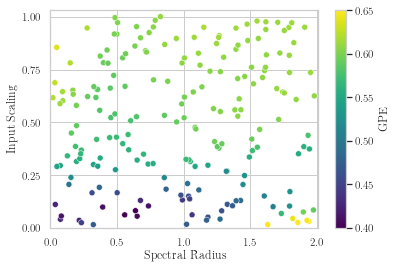

In [27]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = - df["mean_test_score"]
df[df["mean_test_score"] > 0.65] = 0.65
fig, axs = plt.subplots()
sns.scatterplot(x="param_spectral_radius", y="param_input_scaling",
                hue="mean_test_score", palette='viridis', data=df, ax=axs)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(0.4, 0.65)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
# sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
axs.get_legend().remove()
axs.figure.colorbar(sm, label='GPE')
axs.yaxis.set_major_locator(ticker.MaxNLocator(5))
axs.xaxis.set_major_locator(ticker.MaxNLocator(5))
# plt.savefig('optimize_is_sr_50.pdf', bbox_inches='tight', pad_inches=0)

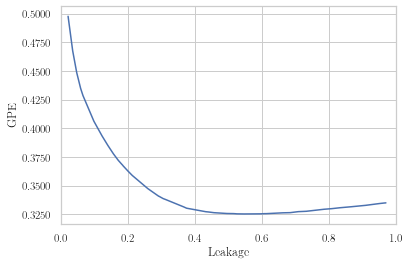

In [28]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig, axs = plt.subplots()
sns.lineplot(data=df, x="param_leakage", y="mean_test_score", ax=axs)
plt.xlabel("Leakage")
plt.ylabel("GPE")
plt.xlim((0, 1))
tick_locator = ticker.MaxNLocator(5)
axs.xaxis.set_major_locator(tick_locator)
axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
# plt.grid()
# plt.savefig('optimize_leakage_50.pdf', bbox_inches='tight', pad_inches=0)

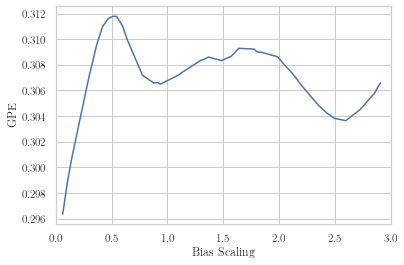

In [29]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig, axs = plt.subplots()
sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score", ax=axs)
plt.xlabel("Bias Scaling")
plt.ylabel("GPE")
plt.xlim((0, 3))
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
# plt.grid()
# plt.savefig('optimize_bias_scaling_50.pdf', bbox_inches='tight', pad_inches=0)

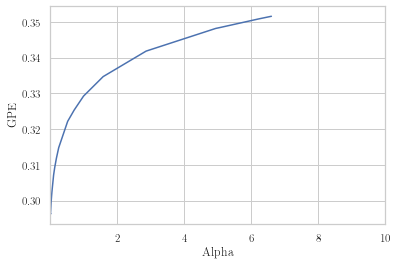

In [30]:
df = pd.DataFrame(sequential_search.all_cv_results_["step4"])
df["mean_test_score"] = -df["mean_test_score"]
fig, axs = plt.subplots()
sns.lineplot(data=df, x="param_alpha", y="mean_test_score", ax=axs)
plt.xlabel("Alpha")
plt.ylabel("GPE")
plt.xlim((1e-5, 10))
ax.set(xscale='log')
tick_locator = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(tick_locator)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.5f'))
# plt.grid()
# plt.savefig('optimize_alpha_50.pdf', bbox_inches='tight', pad_inches=0)

In [31]:
sequential_search.all_best_params_

{'step1': {'input_scaling': 0.061478751249989354,
  'spectral_radius': 0.5572929284732229},
 'step2': {'leakage': 0.5467202793432796},
 'step3': {'bias_scaling': 0.06175348288740734},
 'step4': {'alpha': 6.870101665590024e-05}}

In [93]:
important_params = {"input_scaling": sequential_search.all_best_params_["step1"]["input_scaling"],
                    **sequential_search.all_best_params_["step3"] }
important_params

{'input_scaling': 0.016952130531190705, 'bias_scaling': 0.5454749016213019}

## Final evaluation

Increase the reservoir size from 50 neurons as large as possible by doubling the value

In [137]:
print("Parameters\tFit time KM\tFit time ESN\tInference time\tGPE\tFPE\tVDE")
param_grid = {'hidden_layer_size': [50, 100, 200, 400, 500, 800, 1000, 1600],
              'random_state': [1, 2, 3, 4, 5]}
for params in ParameterGrid(param_grid):
    kmeans = MiniBatchKMeans(n_clusters=params["hidden_layer_size"], n_init=200,
                             reassignment_ratio=0, max_no_improvement=50,
                             init='k-means++', verbose=0,
                             random_state=params["random_state"])
    t1 = time.time()
    kmeans.fit(X=np.concatenate(np.concatenate((X_train, X_test))))
    t2 = time.time()
    w_in = np.divide(kmeans.cluster_centers_,
                     np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
    esn = clone(sequential_search.best_estimator_).set_params(**params)
    esn.input_to_node = PredefinedWeightsInputToNode(
        predefined_input_weights = w_in.T).set_params(**important_params)
    t3 = time.time()
    esn.fit(X_train, y_train, n_jobs=-1)
    t4 = time.time()
    y_pred = esn.predict(X_test)
    t5 = time.time()
    print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}"
          .format(params, t2-t1, t4-t3, t5-t4, gpe_scorer(y_test, y_pred),
                  fpe_scorer(y_test, y_pred), vde_scorer(y_test, y_pred)))

Parameters	Fit time KM	Fit time ESN	Inference time	GPE	FPE	VDE


c:\users\steiner\.virtualenvs\pyrcn\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
c:\users\steiner\.virtualenvs\pyrcn\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in subtract


{'hidden_layer_size': 1600}	723.7067713737488	4538.394070863724	1001.1067538261414	0.34746864286378876	7.693037006852206	0.043532296002853244


In [ ]:
df = pd.DataFrame(gs.cv_results_)
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(3.2, 1.5)
ax = sns.boxplot(data=df, x="param_hidden_layer_size", y="mean_test_score")
plt.xlabel(r"Hidden Layer Size", fontsize=8)
plt.ylabel(r"GPE", fontsize=8)
# ax.set(xscale='linear')
# ax.set(xlim=(0, 16500))
ax.set(ylim=(0.2, 0.6))
tick_locator = ticker.MaxNLocator(10)
ax.xaxis.set_major_locator(tick_locator)
tick_locator = ticker.MaxNLocator(4)
ax.yaxis.set_major_locator(tick_locator)
ax.set_yticklabels(ax.get_yticks(), size = 8)
ax.tick_params(labelsize=8)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.xticks(rotation=90)
# plt.grid()
plt.savefig('dense_km_esn_final_validation.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
sequential_search.best_estimator_.node_to_node.n_features_in_

In [ ]:
#list the files
path = os.path.abspath(r"C:\Users\Steiner\Documents\Python\PyRCN\f0\PTDB_TUG")
filelist = os.listdir(path) 
#read them into pandas
df_list = [pd.read_csv(os.path.join(path, f), sep=" ", skiprows=lambda idx: idx < 7, header=None) for f in filelist]
#concatenate them together
reaper_df = pd.concat(df_list)
reaper_df.columns = ["time", "Voicing", "f0"]
all_y_reaper = reaper_df[["f0"]].to_numpy()
fig, ax = plt.subplots()
fig.set_size_inches(2.5, 1.2)
ax = sns.histplot(x=all_y_reaper[all_y_reaper != -1], stat="count", legend=False)  # , log_scale=True
plt.xlabel(r"$f_{0}$ in Hertz", fontsize=8)
plt.ylabel(r"Count", fontsize=8)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([50, 100, 200, 400])
ax.set_xlim([50, 300])
ax.set_ylim([0, 55000])
ax.tick_params(labelsize=8)
plt.minorticks_off()
plt.savefig('ptdb_tug_reaper.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
#list the files
path = os.path.abspath(r"C:\Users\Steiner\Documents\Python\PyRCN\f0\VCTK")
filelist = os.listdir(path) 
#read them into pandas
df_list = [pd.read_csv(os.path.join(path, f), sep=" ", skiprows=lambda idx: idx < 7, header=None) for f in filelist]
#concatenate them together
reaper_df = pd.concat(df_list)
reaper_df.columns = ["time", "Voicing", "f0"]
all_y_reaper = reaper_df[["f0"]].to_numpy()
fig, ax = plt.subplots()
fig.set_size_inches(4, 2.5)
ax = sns.histplot(x=all_y_reaper[all_y_reaper != -1], stat="count")  # , log_scale=True
ax.set(xlabel=r'$f_{0}$ in Hertz', ylabel='Count')
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([50, 100, 200, 400])
ax.set_xlim([40, 400])
plt.minorticks_off()
plt.grid()

In [ ]:
param_grid = {'hidden_layer_size': [50,100,200,400,500,800,1000,1600,2000,3200,4000,6400,8000,16000],
              'k': [0,1,2,3,4,5,6]}

print("hidden_layer_size,supervised_st,unsupervised_st,GPE,FPE,VDE,FFE")
for params in ParameterGrid(param_grid):
    esn = load("../f0/esn_" + str(params["hidden_layer_size"]) + "_" + str(params["k"]) + ".joblib")
    y_pred = esn.predict(X_test)
    print("{0},{1},{2},{3},{4},{5},{6}".format(params["hidden_layer_size"],params["k"],params["k"],
                                               gpe_scorer(y_test, y_pred),
                                               fpe_scorer(y_test, y_pred),
                                               vde_scorer(y_test, y_pred),
                                               ffe_scorer(y_test, y_pred)))

In [ ]:
param_grid = {'hidden_layer_size': [50,100,200,400,500,800,1000,1600,2000,3200,4000,6400,8000,16000],
              'k': [0,1,2,3,4,5,6]}

print("hidden_layer_size,supervised_st,unsupervised_st,GPE,FPE,VDE,FFE")
for params in ParameterGrid(param_grid):
    esn = load("../f0/km_esn_dense_" + str(params["hidden_layer_size"]) + "_0_" + str(params["k"]) + ".joblib")
    y_pred = esn.predict(X_test)
    print("{0},{1},{2},{3},{4},{5},{6}".format(params["hidden_layer_size"],params["k"],params["k"],
                                               gpe_scorer(y_test, y_pred),
                                               fpe_scorer(y_test, y_pred),
                                               vde_scorer(y_test, y_pred),
                                               ffe_scorer(y_test, y_pred)))

In [ ]:
param_grid = {'hidden_layer_size': [50,100,200,400,500,800,1000,1600,2000,3200,4000,6400,8000,16000],
              'k': [0,1,2,3,4,5,6]}

print("hidden_layer_size,supervised_st,unsupervised_st,GPE,FPE,VDE,FFE")
for params in ParameterGrid(param_grid):
    esn = load("../f0/km_esn_dense_" + str(params["hidden_layer_size"]) + "_" + str(params["k"]) + "_0.joblib")
    y_pred = esn.predict(X_test)
    print("{0},{1},{2},{3},{4},{5},{6}".format(params["hidden_layer_size"],params["k"],params["k"],
                                               gpe_scorer(y_test, y_pred),
                                               fpe_scorer(y_test, y_pred),
                                               vde_scorer(y_test, y_pred),
                                               ffe_scorer(y_test, y_pred)))

In [ ]:
param_grid = {'hidden_layer_size': [50,100,200,400,500,800,1000,1600,2000,3200,4000,6400,8000,16000],
              'k': [0,1,2,3,4,5,6]}

print("hidden_layer_size,supervised_st,unsupervised_st,GPE,FPE,VDE,FFE")
for params in ParameterGrid(param_grid):
    esn = load("../f0/km_esn_dense_" + str(params["hidden_layer_size"]) + "_" + str(params["k"]) + "_" + str(params["k"]) + ".joblib")
    y_pred = esn.predict(X_test)
    print("{0},{1},{2},{3},{4},{5},{6}".format(params["hidden_layer_size"],params["k"],params["k"],
                                               gpe_scorer(y_test, y_pred),
                                               fpe_scorer(y_test, y_pred),
                                               vde_scorer(y_test, y_pred),
                                               ffe_scorer(y_test, y_pred)))

In [ ]:
df1 = pd.read_csv("../f0/basic_esn_final.csv", sep=",")
df2 = pd.read_csv("../f0/km_esn_only_supervised.csv", sep=",")
df3 = pd.read_csv("../f0/km_esn_only_unsupervised.csv", sep=",")
df4 = pd.read_csv("../f0/km_esn_completely_augmented.csv", sep=",")

In [ ]:
df1["GPE"] = 100*df1["GPE"]
df2["GPE"] = 100*df2["GPE"]
df3["GPE"] = 100*df3["GPE"]
df4["GPE"] = 100*df4["GPE"]
df1["VDE"] = 100*df1["VDE"]
df2["VDE"] = 100*df2["VDE"]
df3["VDE"] = 100*df3["VDE"]
df4["VDE"] = 100*df4["VDE"]

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.3)
sns.lineplot(data=df1[df1['supervised\_st'] == 0], x="hidden\_layer\_size", y="GPE", marker="o", ax=ax, err_style="bars")
sns.lineplot(data=df2[df2['supervised\_st'] == 0], x="hidden\_layer\_size", y="GPE", marker="o", ax=ax, err_style="bars")
ax.set_xlim([44, 17500])
ax.set(xscale="log")
ax.tick_params(labelsize=8)
plt.legend(labels=["Basic ESN","KM-ESN"],prop={'size': 8})
tick_locator = ticker.LogLocator(base=10.0, subs=(1.0,), numdecs=5, numticks=10)
ax.xaxis.set_major_locator(tick_locator)
plt.xlabel("Reservoir size", fontsize=8)
plt.ylabel("GPE in \%", fontsize=8)
# ax.set_ylim([0, 22000])
plt.savefig('GPE_test.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.3)
sns.lineplot(data=df1[df1['supervised\_st'] == 0], x="hidden\_layer\_size", y="VDE", marker="o", ax=ax, err_style="bars")
sns.lineplot(data=df2[df2['supervised\_st'] == 0], x="hidden\_layer\_size", y="VDE", marker="o", ax=ax, err_style="bars")
ax.set_xlim([44, 17500])
ax.set(xscale="log")
ax.tick_params(labelsize=8)
plt.legend(labels=["Basic ESN","KM-ESN"],prop={'size': 8})
tick_locator = ticker.LogLocator(base=10.0, subs=(1.0,), numdecs=5, numticks=10)
ax.xaxis.set_major_locator(tick_locator)
plt.xlabel("Reservoir size", fontsize=8)
plt.ylabel("VDE in \%", fontsize=8)
# ax.set_ylim([0, 22000])
plt.savefig('VDE_test.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
plt.rcParams['legend.title_fontsize'] = 8
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.3)
sns.lineplot(data=df1, x="hidden\_layer\_size", y="GPE", hue="supervised\_st", marker="o", ax=ax, err_style="bars")
ax.set_xlim([44, 17500])
ax.set(xscale="log")
ax.tick_params(labelsize=8)
l = plt.legend(["0 st", "1 st", "2 st", "3 st", "4 st", "5 st", "6 st"], 
               title="Pitch shift\n up to", 
               prop={'size': 8},
               loc='center left', 
               bbox_to_anchor=(1.0, 0.5))
plt.setp(l.get_title(), multialignment='center')
tick_locator = ticker.LogLocator(base=10.0, subs=(1.0,), numdecs=5, numticks=10)
ax.xaxis.set_major_locator(tick_locator)
plt.xlabel("Reservoir size", fontsize=8)
plt.ylabel("GPE in \%", fontsize=8)
ax.set_ylim([27, None])
plt.savefig('Basic_ESN_augmented_GPE.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(3.2, 1.3)
sns.lineplot(data=df2, x="hidden\_layer\_size", y="GPE", hue="supervised\_st", marker="o", ax=ax, legend=False, err_style="bars")
ax.set_xlim([44, 17500])
ax.set(xscale="log")
ax.tick_params(labelsize=8)
tick_locator = ticker.LogLocator(base=10.0, subs=(1.0,), numdecs=5, numticks=10)
ax.xaxis.set_major_locator(tick_locator)
plt.xlabel("Reservoir size", fontsize=8)
plt.ylabel("GPE in \%", fontsize=8)
ax.set_ylim([27, None])
plt.savefig('KM_ESN_augmented_GPE.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
df4.head()